In [1]:
import numpy as np
import pandas as pd
import mat73
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks, correlate
from scipy.fftpack import fft, fftfreq
from functools import lru_cache
from pathlib import Path

## Load personal written functions here 
from detect_tail_bouts import detect_tail_bouts
from tail_behaviour_tools import plot_tail_with_bouts, summarize_bouts_stim_aligned
from tail_bout_summaries import extract_tail_bout_features_and_windows
from stimulus_locked_behaviour import stimulus_locked_behaviour
from neuro_behaviour_alignment import neural_to_behaviour_alignment_single_roi
#from population_mapping_extended import population_level_mapping_extended

import warnings
warnings.filterwarnings('ignore')

In [2]:
@lru_cache(maxsize=50)
def import_2p_data(path_to_file_of_interest):
    df = mat73.loadmat(path_to_file_of_interest, use_attrdict=True)
    return df

In [3]:
## Load eye movement data
wt_gmb = Path("/Users/gwk/Desktop/CalciumImaging/Wt_Unexposed/f1/gmb.mat")
wt2_gmb = Path("/Users/gwk/Desktop/CalciumImaging/Wt_Unexposed/f1/gmb.mat")
wte_gmb = Path("/Users/gwk/Desktop/CalciumImaging/Wt_exposed/f2/gmb.mat")
mute_gmb = Path("/Users/gwk/Desktop/CalciumImaging/Mut_exposed/f1/gmb.mat")
mute_gmb1 = Path("/Users/gwk/Desktop/CalciumImaging/Mut_exposed/7_dpf/f1/gmb.mat")
mute_gmb2 = Path("/Users/gwk/Desktop/CalciumImaging/Mut_exposed/7_dpf/f2/gmb.mat")
mute_gmb3 = Path("/Users/gwk/Desktop/CalciumImaging/Mut_exposed/7_dpf/f3/gmb.mat")

In [4]:
gmb_wt, gmb_wt2, gmb_wte = import_2p_data(wt_gmb),import_2p_data(wt2_gmb),import_2p_data(wte_gmb)
gmb_mute, gmb1_mute, gmb2_mute, gmb3_mute = import_2p_data(mute_gmb), import_2p_data(mute_gmb1),import_2p_data(mute_gmb2), import_2p_data(mute_gmb3)

In [5]:
## Load tail movement data here 

In [6]:
wt_gmbt = Path("/Users/gwk/Desktop/CalciumImaging/Wt_Unexposed/f1/gmbt.mat")
wt2_gmbt = Path("/Users/gwk/Desktop/CalciumImaging/Wt_Unexposed/f1/gmbt.mat")
wte_gmbt = Path("/Users/gwk/Desktop/CalciumImaging/Wt_exposed/f2/gmbt.mat")
mute_gmbt = Path("/Users/gwk/Desktop/CalciumImaging/Mut_exposed/f1/gmbt.mat")
mute_gmbt1 = Path("/Users/gwk/Desktop/CalciumImaging/Mut_exposed/7_dpf/f1/gmbt.mat")
mute_gmbt2 = Path("/Users/gwk/Desktop/CalciumImaging/Mut_exposed/7_dpf/f2/gmbt.mat")
mute_gmbt3 = Path("/Users/gwk/Desktop/CalciumImaging/Mut_exposed/7_dpf/f3/gmbt.mat")

In [7]:
gmbt_wt, gmbt_wt2, gmbt_wte = import_2p_data(wt_gmbt),import_2p_data(wt2_gmbt),import_2p_data(wte_gmbt)
gmbt_mute, gmbt1_mute, gmbt2_mute, gmbt3_mute = import_2p_data(mute_gmbt), import_2p_data(mute_gmbt1),import_2p_data(mute_gmbt2), import_2p_data(mute_gmbt3)

In [8]:
## lOOM FRONTAL (LF) AND loom control frontal, dimming (LCF)
LF = [5100.0, 0, 10, 490, 5.66]
LCF = [6100.0, 0.0, 10.0, 490.0, 5.66]

epoch_lf,epoch_lcf, = [],[]
v_stim = []
for num in range(0, 296):
    stim = gmbt_wt['gmbt']['p'][num]['visstim'][0:5]
    if stim.tolist() == LF:
        epoch_lf.append(num)
    elif stim.tolist() == LCF:
        epoch_lcf.append(num)

In [9]:
## OKR STIMULUS TYPE
OKR1 = [2090.0, 0.40, 12.14, 0.86, 12.00]
OKR2 = [2090.0, 0.40, 39.68, 2.82, 12.00]
OKR3 = [2090.0, 0.08, 12.14, 0.86, 12.00]
OKR4 = [2090.0, 0.20, 12.14, 0.86, 12.00]
OKR5 = [2090.0, 0.40, 26.04, 1.82, 12.00]
epoch_okr1,epoch_okr2,epoch_okr3,epoch_okr4, epoch_okr5 = [],[],[],[],[]
v_stim = []
for num in range(0, 296):
    stim = gmbt_wt['gmbt']['p'][num]['visstim'][0:5]
    if stim.tolist() == OKR1:
        epoch_okr1.append(num)
    elif stim.tolist() == OKR2:
        epoch_okr2.append(num)
    elif stim.tolist() == OKR3:
        epoch_okr3.append(num)
    elif stim.tolist() == OKR4:
        epoch_okr4.append(num)
    elif stim.tolist() == OKR5:
        epoch_okr5.append(num)

In [10]:
## lOOM FRONTAL (LF) AND loom control frontal, dimming (LCF)
LMB1 = [3006.0, 0, 4, 30, 10]
LMB2 = [3006.0, 0, 12, 30, 10]
LMB3 = [3006.0, 2, 4, 30, 10]
LMB4 = [3006.0, 2, 12, 30, 10]

RMB1 = [3007.0, 0, 4, 30, 10]
RMB2 = [3007.0, 0, 12, 30, 10]
RMB3 = [3007.0, 2, 4, 30, 10]
RMB4 = [3007.0, 2, 12, 30, 10]

epoch_lmb1, epoch_lmb2, epoch_lmb3, epoch_lmb4 = [],[], [],[]
epoch_rmb1, epoch_rmb2, epoch_rmb3, epoch_rmb4 = [],[], [],[]

for num in range(0, 295+1):
    stim = gmbt_wt['gmbt']['p'][num]['visstim'][0:5]
    if stim.tolist() == LMB1:
        epoch_lmb1.append(num)
    elif stim.tolist() == LMB2:
        epoch_lmb2.append(num)
    elif stim.tolist() == LMB3:
        epoch_lmb3.append(num)
    elif stim.tolist() == LMB4:
        epoch_lmb4.append(num)
    elif stim.tolist() == RMB1:
        epoch_rmb1.append(num)
    elif stim.tolist() == RMB2:
        epoch_rmb2.append(num)
    elif stim.tolist() == RMB3:
        epoch_rmb3.append(num)
    elif stim.tolist() == RMB4:
        epoch_rmb4.append(num)    

In [21]:
epoch = 11
ep = pd.DataFrame({'Time':df['gmbt']['p'][epoch]['fr'], 'angle_deg':df['gmbt']['p'][epoch]['cumtail']}, index=None)
#ep.to_csv(f'./data/tail.csv', index=False)

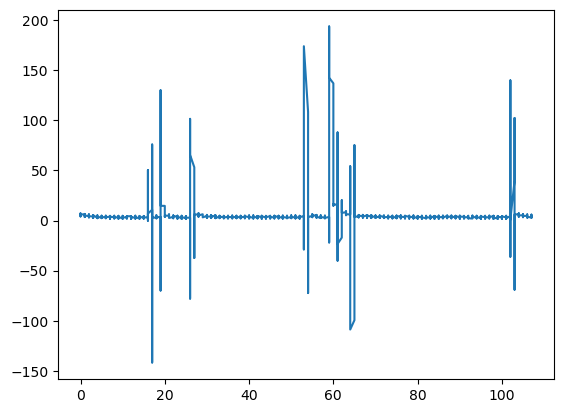

In [22]:
plt.plot(ep['Time'], ep['angle_deg'])
plt.show()

In [30]:
# df_tail: 2 columns -> [time, angle_deg]
# If your time column is frames (0..108), pass fs=3.6 to convert to seconds.

bouts, info = detect_tail_bouts(ep, fs=3.6,  # set None if time is already seconds
                                smooth_window=5,
                                z_high=2.50, z_low=1.5,
                                min_duration_s=0.08,
                                min_inter_bout_s=0.10)

bouts.head()


,onset_idx,offset_idx,onset_time,offset_time,duration_s,peak_speed_deg_s,mean_speed_deg_s,angle_amp_deg,rms_speed_deg_s
0,14,23,3.888889,6.388889,2.500000,4.917380,3.642353,5.294311,3.919735
1,24,32,6.666667,8.888889,2.222222,2.631678,1.553676,2.067718,1.681482
2,50,53,13.888889,14.722222,0.833333,3.077488,1.829315,1.972857,2.030366
3,56,69,15.555556,19.166667,3.611111,36.719923,12.110519,24.487409,16.714592
4,99,107,27.500000,29.722222,2.222222,5.464819,2.773427,4.250163,3.236876


,stim_time_s,responded,latency_s,pre_count,during_count,post_count,pre_rate_hz,during_rate_hz,post_rate_hz,pre_median_peak_speed,during_median_peak_speed,post_median_peak_speed,pre_median_angle_amp,during_median_angle_amp,post_median_angle_amp
0,3.055556,1,0.833333,0,3,2,0.0,0.276923,0.126316,NaN,3.077488,21.092371,NaN,2.067718,14.368786


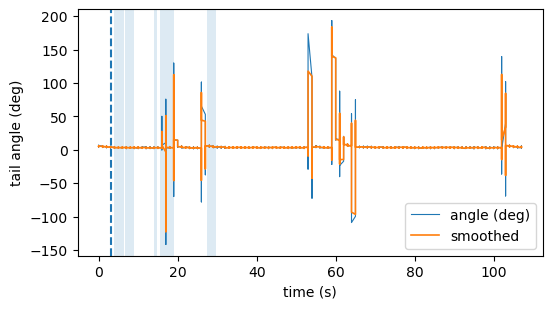

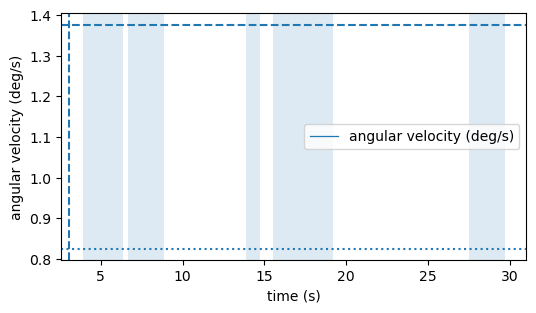

In [31]:
# Inputs:
#  - df_tail: 2 columns [time, angle_deg] (time = frames or seconds)
#  - bouts, info: from detect_tail_bouts(...)

# 1) Plots (PNG saved if you pass save_prefix)
figs = plot_tail_with_bouts(
    ep, bouts, info,
    fs=3.6,              # set None if df_tail time is already seconds
    smooth_window=5,
    stim_frame=11,
    save_prefix="./tail_example"  # creates ..._angle.png and ..._velocity.png
)

# 2) Stimulus-locked summary (single-trial row)
summ = summarize_bouts_stim_aligned(
    bouts,
    fs=3.6,
    total_frames=108,
    stim_frame=11,
    during_start=12, during_end=50, post_start=51,
    response_window_s=(0.0, 2.0)     # count “responses” within 2 s after stimulus
)
summ


In [175]:
saveData = 'wt_unexposed2'

In [32]:
'''
# A) If you already have a bouts DataFrame (with onset_time/offset_time columns):
out = extract_tail_bout_features_and_windows(
    bouts,                      # your bouts DataFrame
    data_is_bouts=True,
    fs=3.6, total_frames=108,
    stim_frame=11, during_start=12, during_end=50, post_start=51,
    response_window_s=(0.0, 2.0),
    save_prefix="./tail_trial01"
)
'''
# B) If you have raw tail data with 2 columns: time, angle_deg:
out = extract_tail_bout_features_and_windows(
    ep,                       # 2 columns (time, angle_deg)
    data_is_bouts=False,           # will auto-detect bouts
    fs=3.6, total_frames=108,
    stim_frame=11, during_start=12, during_end=50, post_start=51,
    # detector tuning (optional):
    smooth_window=5, z_high=3.0, z_low=1.5,
    min_duration_s=0.08, min_inter_bout_s=0.10,
    response_window_s=(0.0, 2.0),
    save_prefix=f"./wt_result/unexposed/{saveData}"
)

# Inspect in-notebook:
out["bouts_df"].head(), out["window_summary_df"]


NameError: name 'saveData' is not defined

In [179]:
bout_trial = out["bouts_df"]

In [181]:
bout_trial.head()

,onset_idx,offset_idx,onset_time,offset_time,duration_s,peak_speed_deg_s,mean_speed_deg_s,angle_amp_deg,rms_speed_deg_s,window_class,latency_from_stim_s
0,0,3,0.000000,0.833333,0.833333,1.528401,0.970151,0.870987,1.136054,pre,NaN
1,4,8,1.111111,2.222222,1.111111,0.746277,0.463408,0.414598,0.514529,pre,NaN
2,9,30,2.500000,8.333333,5.833333,11.685703,2.825263,9.435682,4.278364,pre,NaN
3,78,81,21.666667,22.500000,0.833333,1.290368,0.655680,0.685981,0.820472,post,18.611111
4,82,83,22.777778,23.055556,0.277778,0.796544,0.509028,0.422772,0.584616,post,19.722222


In [184]:
# Input: a single bouts DataFrame OR a list of per-trial bouts DataFrames.
# Each bouts DataFrame should have (at least) 'onset_time' (seconds) and, if available, 'peak_speed_deg_s'.

from stimulus_locked_behaviour import stimulus_locked_behaviour

out = stimulus_locked_behaviour(
    bouts_trials=pd.DataFrame(bout_trial), #[bouts_trial1, bouts_trial2, bouts_trial3],  # or a single DataFrame
    fs=3.6,
    total_frames=108,
    stim_frame=11,
    response_window_s=(0.0, 2.0),  # define "responded" window after stimulus
    save_prefix="./wt_result/unexposed/stim_locked_example"
)

out["psth_df"].head(), out["latency_stats_df"]


IndexError: single positional indexer is out-of-bounds

In [185]:
import numpy as np
import pandas as pd
import os

def stimulus_locked_behaviour_v2(
    bouts_trials,                  # a single DataFrame or list of DataFrames
    fs: float = 3.6,
    total_frames: int = 108,
    stim_frame: int = 11,
    response_window_s=(0.0, 2.0),  # window after stim for “responded”
    match_tol_s: float = None,     # nearest-match tolerance for vigor lookup
    save_prefix: str = None
):
    """
    Robust stimulus-locked behaviour summary with tolerant vigor lookup.

    Expected columns in each bouts DF:
        - onset_time  (seconds)  [required]
        - peak_speed_deg_s       [optional; used for vigor summaries]
    Returns dict with PSTH/latency/response-probability tables.
    """
    if isinstance(bouts_trials, pd.DataFrame):
        trials = [bouts_trials.copy()]
    else:
        trials = [df.copy() for df in bouts_trials]

    for df in trials:
        if "onset_time" not in df.columns:
            raise ValueError("Each bouts DataFrame must contain 'onset_time' (seconds).")

    if match_tol_s is None:
        match_tol_s = 1.0 / fs  # one frame by default

    # time geometry
    t = np.arange(total_frames) / fs
    t0 = stim_frame / fs
    rel_time = t - t0

    # PSTH (frame resolution)
    psth_counts = np.zeros_like(t, dtype=float)

    # Per-trial stats
    rows_latency = []
    rows_prob = []
    vigor_vals_by_frame = [[] for _ in range(total_frames)]  # for optional mean vigor per frame

    win_lo, win_hi = response_window_s

    # helper: nearest vigor
    def _nearest_vigor(df, onset_s, tol_s):
        if "peak_speed_deg_s" not in df.columns:
            return np.nan
        if df.empty:
            return np.nan
        arr = df["onset_time"].to_numpy(dtype=float)
        j = int(np.nanargmin(np.abs(arr - onset_s)))
        if np.abs(arr[j] - onset_s) <= tol_s:
            return float(df["peak_speed_deg_s"].iloc[j]) if "peak_speed_deg_s" in df.columns else np.nan
        return np.nan

    # iterate trials
    for tr_i, df in enumerate(trials, start=1):
        ons_s = df["onset_time"].to_numpy(dtype=float)
        ons_fr = np.clip(np.floor(ons_s * fs).astype(int), 0, total_frames - 1)

        # raster & vigor per frame
        for s, f in zip(ons_s, ons_fr):
            psth_counts[f] += 1.0
            vig = _nearest_vigor(df, s, match_tol_s)
            if np.isfinite(vig):
                vigor_vals_by_frame[f].append(vig)

        # trial-level latency and response probability in the response window
        rel_s = ons_s - t0
        in_win = (rel_s >= win_lo) & (rel_s <= win_hi)
        responded = bool(np.any(in_win))
        latency = float(np.nanmin(rel_s[in_win])) if responded else np.nan
        rows_latency.append({"trial": tr_i, "latency_s": latency})
        rows_prob.append({"trial": tr_i, "responded": int(responded)})

    # build outputs
    psth_df = pd.DataFrame({
        "frame": np.arange(total_frames),
        "time_rel_s": rel_time,
        "count": psth_counts
    })

    # optional mean vigor per frame (if present)
    mean_vigor = [np.nan if len(v)==0 else float(np.nanmean(v)) for v in vigor_vals_by_frame]
    psth_df["mean_vigor_deg_s"] = mean_vigor

    latency_stats_df = pd.DataFrame(rows_latency)
    response_prob_df = pd.DataFrame(rows_prob)
    # aggregate response probability
    resp_prob_summary = pd.DataFrame({
        "n_trials": [len(trials)],
        "n_responded": [int(response_prob_df["responded"].sum())],
        "response_probability": [float(response_prob_df["responded"].mean())]
    })

    out = {
        "psth_df": psth_df,
        "latency_stats_df": latency_stats_df,
        "response_prob_df": response_prob_df,
        "response_prob_summary": resp_prob_summary
    }

    # optional save
    if save_prefix is not None:
        os.makedirs(os.path.dirname(save_prefix) or ".", exist_ok=True)
        psth_df.to_csv(f"{save_prefix}_psth.csv", index=False)
        latency_stats_df.to_csv(f"{save_prefix}_latency.csv", index=False)
        response_prob_df.to_csv(f"{save_prefix}_resp_trials.csv", index=False)
        resp_prob_summary.to_csv(f"{save_prefix}_resp_summary.csv", index=False)

    return out


In [186]:
out = stimulus_locked_behaviour_v2(
    bouts_trials=pd.DataFrame(bout_trial),
    fs=3.6, total_frames=108, stim_frame=11,
    response_window_s=(0.0, 2.0),
    save_prefix="./wt_result/unexposed/stim_locked_example"
)

In [115]:
# === Stage 5 (extended): population-level mapping  ============================
# - Uses responsive-only ROIs per window (pre/during/post)
# - Consumes precomputed, stimulus-aligned PC time-series if provided
# - Otherwise runs PCA per window and returns PC loadings
# - Computes ETA around bout onsets, encoding (R²) and decoding (AUC)
# - Moran’s I retinotopic clustering with NumPy-only kNN weights
# - Saves tidy CSVs + lightweight plots
#
# Usage after running this cell:
# out = population_level_mapping_extended(dff_smooth, fs=3.6, stim_frame=11, during_start=12, during_end=50,
#                                         post_start=51, responsive_only=True, pre_df=pre_resp_df,
#                                         during_df=dur_resp_df, post_df=post_resp_df,
#                                         precomputed_pcs_ts=pc_timeseries_df, bouts_df=bouts_df,
#                                         roi_xy=roi_coords_df, save_prefix="/Users/gwk/Desktop/CalciumImaging/popmap_ext")

import numpy as np, pandas as pd, matplotlib.pyplot as plt, os
from typing import Dict, Tuple, Optional, Union, List

def population_level_mapping_extended(
    dff_smooth: Union[pd.DataFrame, np.ndarray],
    fs: float = 3.6,
    stim_frame: int = 11, during_start: int = 12, during_end: int = 50, post_start: int = 51,
    responsive_only: bool = True,
    pre_df: Optional[pd.DataFrame] = None, during_df: Optional[pd.DataFrame] = None, post_df: Optional[pd.DataFrame] = None,
    precomputed_pcs_ts: Optional[pd.DataFrame] = None,  # ['class','time_s','pc1_score',...]
    n_pcs: int = 5,
    bouts_df: Optional[pd.DataFrame] = None,    # needs 'onset_time' (s)
    eta_window_s: Tuple[float,float] = (-2.0, 3.0),
    lags_s: Tuple[float,float] = (2.0, 2.0),
    n_folds: int = 5,
    roi_xy: Optional[Union[pd.DataFrame, np.ndarray]] = None,   # ['roi','x','y'] or ndarray (N×2)
    roi_metric_df: Optional[pd.DataFrame] = None, metric_col: Optional[str] = None, moran_from: str = "pc1_loading",
    k_neighbors: int = 8, weight_mode: str = "binary", n_perm: int = 500, take_abs_loadings: bool = False,
    save_prefix: str = "./population_mapping_ext"
) -> Dict[str, Union[pd.DataFrame, str]]:

    # ---- helpers (local, no external deps) ----
    def _ensure_df(x):
        if isinstance(x, pd.DataFrame): return x.copy()
        x = np.asarray(x); df = pd.DataFrame(x); df.columns = [f"ROI_{i+1}" for i in range(df.shape[1])]; return df
    def _windows(nF, sf, ds, de, ps):
        if ps is None: ps = de + 1
        return {"pre": (0, sf), "during": (ds, de), "post": (ps, nF-1)}
    def _mad_sigma(x):
        x = np.asarray(x, float); x = x[np.isfinite(x)]
        if x.size == 0: return np.nan
        med = np.nanmedian(x); mad = np.nanmedian(np.abs(x - med)); return 1.4826*mad + 1e-12
    def _detect_events(y, fs, kH=2.5, kP=2.0, min_d_s=0.5):
        sig = _mad_sigma(y); 
        if not np.isfinite(sig) or sig<=0: sig = np.nanstd(y)+1e-12
        hthr, pthr, mind = kH*sig, kP*sig, max(1, int(round(min_d_s*fs)))
        peaks, last = [], -10**9
        for i in range(1, len(y)-1):
            if y[i] > y[i-1] and y[i] > y[i+1] and y[i] >= hthr and (i-last) >= mind:
                w = max(1, mind//2)
                lmin = np.nanmin(y[max(0,i-w):i]) if i-w >= 0 else y[i-1]
                rmin = np.nanmin(y[i+1:min(len(y), i+1+w)]) if i+1+w <= len(y) else y[i+1]
                if (y[i] - max(lmin, rmin)) >= pthr:
                    peaks.append(i); last = i
        return np.asarray(peaks, int)
    def _responsive_sets(df, fs, wins, pre, dur, post, resp_only=True):
        if not resp_only: return {k:list(df.columns) for k in wins}
        def _take(tbl):
            if tbl is None: return None
            if "roi" in tbl.columns and "responsive" in tbl.columns:
                m = tbl.set_index("roi")["responsive"].astype(bool).to_dict()
            elif "responsive" in tbl.columns:
                m = tbl["responsive"].astype(bool).to_dict()
            else: return None
            return [r for r,v in m.items() if v and r in df.columns]
        out = {}
        tmp = {"pre": _take(pre), "during": _take(dur), "post": _take(post)}
        out.update({k:v for k,v in tmp.items() if v is not None})
        remain = set(wins) - set(out)
        if remain:
            pk = {roi: _detect_events(df[roi].to_numpy(float), fs) for roi in df.columns}
            for cls in remain:
                lo,hi = wins[cls]
                out[cls] = [roi for roi in df.columns if np.any((pk[roi]>=lo)&(pk[roi]<=hi))]
        return out
    def _pca_scores_loadings(W, k):
        X = W.copy()
        for j in range(X.shape[1]):
            col = X[:,j]; med = np.nanmedian(col); col[~np.isfinite(col)] = med; X[:,j] = col
        Xc = X - np.mean(X, axis=0, keepdims=True)
        U,s,Vt = np.linalg.svd(Xc, full_matrices=False) if Xc.size else (np.zeros((Xc.shape[0],0)), np.array([]), np.zeros((0,Xc.shape[1])))
        kk = min(k, Vt.shape[0]) if Vt.size else 0
        if kk==0: return np.zeros((X.shape[0],0)), np.zeros((X.shape[1],0)), np.zeros((0,))
        scores = U[:, :kk] * s[:kk]; loadings = Vt[:kk, :].T
        var = (s**2)/max(1, (Xc.shape[0]-1)); vr = var/np.sum(var) if np.sum(var)>0 else np.zeros_like(var)
        return scores, loadings, vr
    def _build_lagged(X, lags):
        T,K = X.shape; Phi = np.zeros((T, K*len(lags)))
        for j,lag in enumerate(lags):
            if lag<0:   Phi[-lag:, j*K:(j+1)*K] = X[:T+lag,:]
            elif lag>0: Phi[:T-lag, j*K:(j+1)*K] = X[lag:,:]
            else:       Phi[:, j*K:(j+1)*K] = X
        return Phi
    def _block_kfold(T, n=5):
        sizes = np.full(n, T//n, int); sizes[:T % n]+=1
        idx = np.arange(T); splits=[]; st=0
        for f in range(n):
            en = st+sizes[f]; te = idx[st:en]; tr = np.concatenate([idx[:st], idx[en:]])
            splits.append((tr, te)); st = en
        return splits
    def _zscore(X): mu = np.nanmean(X,0); sd = np.nanstd(X,0)+1e-12; return (X-mu)/sd, mu, sd
    def _ols_cv(Phi, y, n=5):
        R2=[]
        for tr,te in _block_kfold(len(y), n):
            Xtr,Xte,ytr,yte = Phi[tr],Phi[te],y[tr],y[te]
            Xtr_z,mu,sd = _zscore(Xtr); Xte_z = (Xte-mu)/sd
            Xtr_ = np.hstack([np.ones((Xtr_z.shape[0],1)), Xtr_z]); Xte_ = np.hstack([np.ones((Xte_z.shape[0],1)), Xte_z])
            w = np.linalg.pinv(Xtr_.T@Xtr_)@(Xtr_.T@ytr); yhat = Xte_@w
            ssr = np.sum((yte-yhat)**2); sst = np.sum((yte-np.mean(yte))**2)+1e-12; R2.append(1-ssr/sst)
        return float(np.mean(R2)), float(np.std(R2))
    def _auc_fast(y_true, scores):
        y = y_true.astype(int); pos = scores[y==1]; neg = scores[y==0]
        if pos.size==0 or neg.size==0: return np.nan
        allv = np.concatenate([pos,neg]); order = np.argsort(allv); ranks = np.empty_like(order,float); ranks[order] = np.arange(1, order.size+1)
        Rpos = np.sum(ranks[:pos.size]); U = Rpos - pos.size*(pos.size+1)/2.0; return float(U/(pos.size*neg.size))
    def _logreg_cv(Phi, y, n=5, l2=1e-2, it=80):
        aucs=[]
        for tr,te in _block_kfold(len(y), n):
            Xtr,Xte,ytr,yte = Phi[tr],Phi[te],y[tr].astype(int),y[te].astype(int)
            Xtr_z,mu,sd = _zscore(Xtr); Xte_z = (Xte-mu)/sd
            Xtr_ = np.hstack([np.ones((Xtr_z.shape[0],1)), Xtr_z]); Xte_ = np.hstack([np.ones((Xte_z.shape[0],1)), Xte_z])
            w = np.zeros(Xtr_.shape[1])
            for _ in range(it):
                z = Xtr_@w; p = 1/(1+np.exp(-z)); W = p*(1-p)+1e-9
                H = (Xtr_.T*W)@Xtr_ + l2*np.eye(Xtr_.shape[1]); g = Xtr_.T@(p-ytr) + l2*w
                try: step = np.linalg.solve(H,g)
                except np.linalg.LinAlgError: step = np.linalg.pinv(H)@g
                w -= step
                if np.linalg.norm(step) < 1e-6: break
            aucs.append(_auc_fast(yte, Xte_@w))
        return float(np.nanmean(aucs)), float(np.nanstd(aucs))
    def _bout_labels(bdf, nF, fs):
        yb = np.zeros(nF,int); yc = np.zeros(nF,float)
        if bdf is None or bdf.empty or "onset_time" not in bdf.columns: return yb,yc
        fr = np.clip(np.floor(bdf["onset_time"].to_numpy()*fs).astype(int), 0, nF-1)
        for f in fr: yb[f]=1; yc[f]+=1.0
        return yb,yc
    def _knn_weights_numpy(xy, k=8, mode="binary", eps=1e-9):
        xy = np.asarray(xy,float); N = xy.shape[0]
        D = np.sqrt(((xy[:,None,:]-xy[None,:,:])**2).sum(2)); np.fill_diagonal(D, np.inf)
        W = np.zeros((N,N)); kk = max(1, min(k, N-1))
        for i in range(N):
            nbr = np.argpartition(D[i], kk)[:kk]
            if mode=="binary": W[i, nbr] = 1.0
            else: W[i, nbr] = 1.0/(D[i, nbr]+eps)
        W = W/(W.sum(1, keepdims=True)+eps); return W
    def _moran_I(z, W):
        z = np.asarray(z,float); zm = z - np.nanmean(z); zm[~np.isfinite(zm)] = 0.0
        S0 = np.sum(W); num = float(zm @ W @ zm); den = float((zm**2).sum())+1e-12
        return float((len(z)/(S0+1e-12))*(num/den))
    def _moran_perm(z, W, n=500, seed=42):
        rng = np.random.default_rng(seed); Iobs = _moran_I(z,W); cnt=0; n=max(10,int(n))
        for _ in range(n):
            Iperm = _moran_I(rng.permutation(z), W); 
            if Iperm >= Iobs: cnt += 1
        return Iobs, float((cnt+1)/(n+1))

    # ---- set-up ----
    os.makedirs(os.path.dirname(save_prefix) or ".", exist_ok=True)
    df = _ensure_df(dff_smooth); nF, nR = df.shape
    wins = _windows(nF, stim_frame, during_start, during_end, post_start)
    resp_sets = _responsive_sets(df, fs, wins, pre_df, during_df, post_df, resp_only=responsive_only)
    y_bin, y_cnt = _bout_labels(bouts_df, nF, fs)
    eta_pre, eta_post = eta_window_s; eta_len = int(round((eta_post - eta_pre)*fs))+1; eta_t = np.arange(eta_len)/fs + eta_pre

    ts_rows, load_rows, enc_rows, dec_rows = [], [], [], []
    eta_pop_acc = {k: [] for k in wins}; eta_pc1_acc = {k: [] for k in wins}

    # ---- per window analyses ----
    for cls,(lo,hi) in wins.items():
        keep = resp_sets.get(cls, list(df.columns)) if responsive_only else list(df.columns)
        W = df.loc[lo:hi, keep].to_numpy(float); T = W.shape[0]; t_win = np.arange(lo,hi+1)/fs
        # precomputed PCs?
        use_pre = False; scores=None
        if precomputed_pcs_ts is not None and not precomputed_pcs_ts.empty:
            sub = precomputed_pcs_ts[precomputed_pcs_ts["class"]==cls]
            if not sub.empty and sub.shape[0]==T:
                arr=[ sub.get(f"pc{i+1}_score", pd.Series(np.full(T,np.nan))).to_numpy(float) for i in range(n_pcs) ]
                scores = np.vstack(arr).T; use_pre=True
        pop_mean = np.nanmean(W,1) if W.size else np.full(T,np.nan)
        if not use_pre:
            if W.size and W.shape[1]>0:
                S,L,vr = _pca_scores_loadings(W, n_pcs); scores=S
                for j,roi in enumerate(keep):
                    row = {"class":cls, "roi":roi}
                    for p in range(min(n_pcs, L.shape[1])): row[f"pc{p+1}_loading"]=float(L[j,p])
                    load_rows.append(row)
            else:
                scores = np.zeros((T,0))
        else:
            for roi in keep:
                load_rows.append({"class":cls, "roi":roi, **{f"pc{p+1}_loading":np.nan for p in range(n_pcs)}})

        # timeseries rows
        ts = {"class":cls, "time_s":t_win, "pop_mean":pop_mean}
        for i in range(n_pcs):
            ts[f"pc{i+1}_score"] = (scores[:,i] if i < scores.shape[1] else np.full(T,np.nan))
        ts_rows.append(pd.DataFrame(ts))

        # ETA around bouts
        if bouts_df is not None and not bouts_df.empty:
            onset = bouts_df["onset_time"].to_numpy()
            in_win = onset[(onset >= lo/fs) & (onset < (hi+1)/fs)]
            for bt in in_win:
                c = int(round(bt*fs))-lo; a0 = c + int(round(eta_pre*fs)); a1 = a0 + eta_len
                if a0<0 or a1>T: continue
                eta_pop_acc[cls].append(pop_mean[a0:a1])
                if scores.shape[1]>=1: eta_pc1_acc[cls].append(scores[a0:a1,0])

        # Encoding/Decoding
        past, fut = lags_s; lags = list(range(-int(round(past*fs)), int(round(fut*fs))+1))
        Phi = _build_lagged(scores, lags) if scores.shape[1]>0 else np.zeros((T,0))
        stim = np.zeros(T); s_lo=max(lo,during_start); s_hi=min(hi,during_end)
        if s_hi>=s_lo: stim[s_lo-lo:s_hi-lo+1] = 1.0
        PhiE = np.hstack([Phi, stim.reshape(-1,1)])
        r2m,r2s = _ols_cv(PhiE, y_cnt[lo:hi+1], n=n_folds) if PhiE.shape[1]>0 else (np.nan,np.nan)
        enc_rows.append({"class":cls,"n_rois_used":len(keep),"n_pcs":scores.shape[1],"lags":len(lags),
                         "encoding_r2_mean":r2m,"encoding_r2_std":r2s})
        yb = y_bin[lo:hi+1]
        if PhiE.shape[1]>0 and np.any(yb==1) and np.any(yb==0):
            aucm,aucs = _logreg_cv(PhiE, yb, n=n_folds, l2=1e-2, it=80)
        else:
            aucm,aucs = (np.nan,np.nan)
        dec_rows.append({"class":cls,"n_rois_used":len(keep),"n_pcs":scores.shape[1],"lags":len(lags),
                         "decoder_auc_mean":aucm,"decoder_auc_std":aucs})

    pop_timeseries = pd.concat(ts_rows, ignore_index=True) if ts_rows else pd.DataFrame()
    pca_loadings   = pd.DataFrame(load_rows) if load_rows else pd.DataFrame()
    encoding_df    = pd.DataFrame(enc_rows).set_index("class").sort_index()
    decoding_df    = pd.DataFrame(dec_rows).set_index("class").sort_index()

    # ETA DataFrame
    eta_rows=[]
    for cls in wins:
        ep = np.nanmean(np.vstack(eta_pop_acc[cls]),0) if len(eta_pop_acc[cls])>0 else np.full(eta_len,np.nan)
        ec = np.nanmean(np.vstack(eta_pc1_acc[cls]),0)  if len(eta_pc1_acc[cls])>0 else np.full(eta_len,np.nan)
        eta_rows.append(pd.DataFrame({"class":cls,"time_rel_s":eta_t,"eta_pop_mean":ep,"eta_pc1":ec}))
    eta_df = pd.concat(eta_rows, ignore_index=True) if eta_rows else pd.DataFrame()

    # Moran’s I
    moran_rows=[]
    if roi_xy is not None:
        if isinstance(roi_xy, pd.DataFrame) and {"roi","x","y"}.issubset(roi_xy.columns):
            mapping = roi_xy.set_index("roi")[["x","y"]]
            mapping = mapping.loc[[c for c in df.columns if c in mapping.index]]
            xy = mapping.to_numpy(float); roi_order = list(mapping.index)
        else:
            arr = np.asarray(roi_xy, float); xy = arr[:,:2]; roi_order = list(df.columns[:xy.shape[0]])
        if xy.shape[0] >= 3:
            W = _knn_weights_numpy(xy, k=k_neighbors, mode=weight_mode)
            for cls in wins:
                if moran_from=="roi_metric" and roi_metric_df is not None and metric_col is not None:
                    sub = roi_metric_df[roi_metric_df["class"]==cls]
                    zmap = sub.set_index("roi")[metric_col].to_dict()
                    z = np.array([zmap.get(r, np.nan) for r in roi_order], float)
                else:
                    if pca_loadings.empty:
                        z = np.full(len(roi_order), np.nan)
                    else:
                        Lsub = pca_loadings[pca_loadings["class"]==cls].set_index("roi")
                        z = Lsub.get("pc1_loading", pd.Series(index=roi_order, dtype=float)).reindex(roi_order).to_numpy(float)
                    if take_abs_loadings: z = np.abs(z)
                if np.isfinite(z).sum() >= 3: I,p = _moran_perm(z, W, n=n_perm, seed=42)
                else: I,p = (np.nan, np.nan)
                moran_rows.append({"class":cls,"metric": (metric_col if moran_from=='roi_metric' else f"pc1_loading{'_abs' if take_abs_loadings else ''}"),
                                   "moran_I":I,"p_perm":p,"N":int(len(z)),"k_neighbors":int(k_neighbors),"weight_mode":weight_mode})
    moran_df = pd.DataFrame(moran_rows) if moran_rows else pd.DataFrame()

    # save
    ts_csv    = f"{save_prefix}_timeseries.csv"
    enc_csv   = f"{save_prefix}_encoding.csv"
    dec_csv   = f"{save_prefix}_decoding.csv"
    eta_csv   = f"{save_prefix}_eta.csv"
    loads_csv = f"{save_prefix}_pca_loadings.csv"
    moran_csv = f"{save_prefix}_moran.csv"
    pop_timeseries.to_csv(ts_csv, index=False)
    encoding_df.to_csv(enc_csv)
    decoding_df.to_csv(dec_csv)
    eta_df.to_csv(eta_csv, index=False)
    pca_loadings.to_csv(loads_csv, index=False)
    moran_df.to_csv(moran_csv, index=False)

    # quick plots (no explicit colors)
    for cls in moran_df["class"].unique() if not moran_df.empty else []:
        # marker size ∝ |metric|
        if isinstance(roi_xy, pd.DataFrame) and {"roi","x","y"}.issubset(roi_xy.columns):
            xy_plot = roi_xy.set_index("roi").loc[[c for c in df.columns if c in roi_xy["roi"].values]][["x","y"]].to_numpy()
            roi_order = [c for c in df.columns if c in roi_xy["roi"].values]
        elif roi_xy is not None:
            arr = np.asarray(roi_xy, float); xy_plot = arr[:len(df.columns), :2]; roi_order = list(df.columns[:xy_plot.shape[0]])
        else:
            xy_plot = None
        if xy_plot is None: continue
        if moran_from=="roi_metric" and roi_metric_df is not None and metric_col is not None:
            sub = roi_metric_df[roi_metric_df["class"]==cls]
            zmap = sub.set_index("roi")[metric_col].to_dict()
            z = np.array([zmap.get(r, np.nan) for r in roi_order], float)
        else:
            Lsub = pca_loadings[pca_loadings["class"]==cls].set_index("roi")
            z = Lsub.get("pc1_loading", pd.Series(index=roi_order, dtype=float)).reindex(roi_order).to_numpy(float)
            if take_abs_loadings: z = np.abs(z)
        plt.figure(figsize=(4.5,4.0))
        plt.scatter(xy_plot[:,0], xy_plot[:,1])
        s = 10.0 + 40.0*(np.nan_to_num(np.abs(z))/(np.nanmax(np.abs(z))+1e-12))
        plt.scatter(xy_plot[:,0], xy_plot[:,1], s=s)
        plt.xlabel("x"); plt.ylabel("y"); plt.title(f"Moran metric ({cls})")
        plt.savefig(f"{save_prefix}_moran_map_{cls}.png", bbox_inches="tight"); plt.close()

    return {
        "pop_timeseries": pop_timeseries,
        "pca_loadings": pca_loadings,
        "encoding_df": encoding_df,
        "decoding_df": decoding_df,
        "eta_df": eta_df,
        "moran_df": moran_df,
        "timeseries_csv": ts_csv,
        "encoding_csv": enc_csv,
        "decoding_csv": dec_csv,
        "eta_csv": eta_csv,
        "pca_loadings_csv": loads_csv,
        "moran_csv": moran_csv
    }


In [87]:
out = population_level_mapping_extended(
    dff_smooth,                 # (frames × ROIs) ΔF/F0
    fs=3.6,
    stim_frame=11, during_start=12, during_end=50, post_start=51,

    # Optionally restrict to responsive ROIs (per window):
    responsive_only=True,
    pre_df=pre_resp_df,         # each has columns ['roi','responsive'] or index=roi
    during_df=dur_resp_df,
    post_df=post_resp_df,

    # (NEW) Consume precomputed, stimulus-aligned PCs:
    # DataFrame with columns: ['class','time_s','pc1_score','pc2_score', ...]
    precomputed_pcs_ts=None,#pc_timeseries_df,  # pass None to re-compute PCA here

    # Behaviour:
    bouts_df=bouts,          # 'onset_time' in seconds (for ETA & models)
    eta_window_s=(-2.0, 3.0),
    lags_s=(2.0, 2.0),
    n_folds=5,

    # (NEW) Retinotopy / spatial clustering:
    # ROI positions as DataFrame ['roi','x','y'] (preferred) or ndarray (N×2) in ROI order
    #roi_xy=roi_coords_df,

    # Option A (default): Moran’s I on PC1 loadings per window
    moran_from="pc1_loading", take_abs_loadings=False,

    # Option B: Moran’s I on a per-ROI metric (e.g., from Stage 4)
    # roi_metric_df=roi_metric_table, metric_col="p_bout_event_diff", moran_from="roi_metric",

    k_neighbors=8, weight_mode="binary", n_perm=500,
    save_prefix="./population_mapping_ext"
)

out["moran_df"], out["encoding_df"], out["decoding_df"]


/var/folders/tw/gqv0n7js2jq59kcm4d30c1nc0000gn/T/ipykernel_6614/3920147036.py:240: RuntimeWarning: Mean of empty slice
  ep = np.nanmean(np.vstack(eta_pop_acc[cls]),0) if len(eta_pop_acc[cls])>0 else np.full(eta_len,np.nan)


(Empty DataFrame
 Columns: []
 Index: [],
         n_rois_used  n_pcs  lags  encoding_r2_mean  encoding_r2_std
 class                                                              
 during            0      0    15     -1.065557e+11     2.131113e+11
 post              0      0    15     -5.223328e+10     4.285953e+10
 pre               0      0    15      1.000000e+00     0.000000e+00,
         n_rois_used  n_pcs  lags  decoder_auc_mean  decoder_auc_std
 class                                                              
 during            0      0    15               0.0              0.0
 post              0      0    15               0.0              0.0
 pre               0      0    15               NaN              NaN)

In [90]:
out.keys()

dict_keys(['pop_timeseries', 'pca_loadings', 'encoding_df', 'decoding_df', 'eta_df', 'moran_df', 'timeseries_csv', 'encoding_csv', 'decoding_csv', 'eta_csv', 'pca_loadings_csv', 'moran_csv'])

In [95]:
out['moran_df'].keys()

RangeIndex(start=0, stop=0, step=1)

In [83]:
dff_smooth = pd.read_csv('./preproccessedData/smoothed_roi.csv', index_col=0)
pre_resp_df = pd.read_csv('./preproccessedData/pre_df.csv', index_col=0)
dur_resp_df = pd.read_csv('./preproccessedData/during_df.csv', index_col=0)
post_resp_df = pd.read_csv('./preproccessedData/post_df.csv', index_col=0)

In [76]:
dff_smooth.head()

,0,1,2,3,4,5,6,7,8,9,...,6471,6472,6473,6474,6475,6476,6477,6478,6479,6480
0,0.885509,0.254933,0.664122,0.593960,0.155551,0.460153,-0.254712,0.247214,0.079530,0.098234,...,0.423785,0.641069,0.199245,0.426934,0.196962,-0.017583,0.366773,0.504514,1.409901,-0.195157
1,1.089914,0.263911,0.725784,0.816760,0.389318,0.337852,0.128403,0.152190,-0.104948,0.766201,...,0.578763,0.467275,0.199429,0.130668,0.325336,0.195213,0.161167,0.466201,1.420895,0.047471
2,1.323258,0.367001,0.618827,0.686642,0.616448,0.120986,0.598851,0.037127,-0.058758,1.112192,...,0.522813,0.207385,-0.071479,0.271502,0.443375,0.509512,0.038706,0.362514,0.823012,0.591585
3,1.247268,0.533456,0.570223,0.073669,0.591008,0.042731,0.522163,0.232792,0.209280,0.873542,...,0.369762,0.038412,-0.086914,0.628119,0.347039,0.592059,0.255849,0.274549,0.065747,0.926538
4,0.694441,0.481209,0.831538,-0.294621,0.282582,0.118942,0.073784,0.561100,0.306495,0.570821,...,0.327177,0.097555,0.501932,0.457132,0.172980,0.341214,0.510261,0.264766,-0.022772,0.663615


In [56]:
ep = pd.DataFrame({'Time':gmb_wte['gmb']['p'][60]['tt'], 'pos_deg':gmb_wte['gmb']['p'][60]['Langles']}, index=None)
ep.to_csv(f'./data/eye.csv', index=False)

In [28]:
for epoch in epoch_lf:
    ep = pd.DataFrame({'Time':gmbt_wte['gmbt']['p'][epoch]['tt'], 'Tail':gmbt_wte['gmbt']['p'][epoch]['cumtail']}, index=None)
    ep.to_csv(f'/Users/gwk/Desktop/CalciumImaging/tail_analysis/wt_exposed/epoch_{epoch}.csv', index=False)

In [105]:
epoch_lmb1

[11, 27, 43, 59, 85, 101, 117, 133, 159, 175, 191, 207, 233, 249, 265, 281]

In [156]:
epoch_lcf

[18, 34, 50, 66, 92, 108, 124, 140, 166, 182, 198, 214, 240, 256, 272, 288]

In [107]:
max(gmb_wt['gmb']['p'][epoch]['Langles'])

13.846553912219392

In [109]:
min(gmb_wt['gmb']['p'][epoch]['Rangles'])

-29.935807639559215

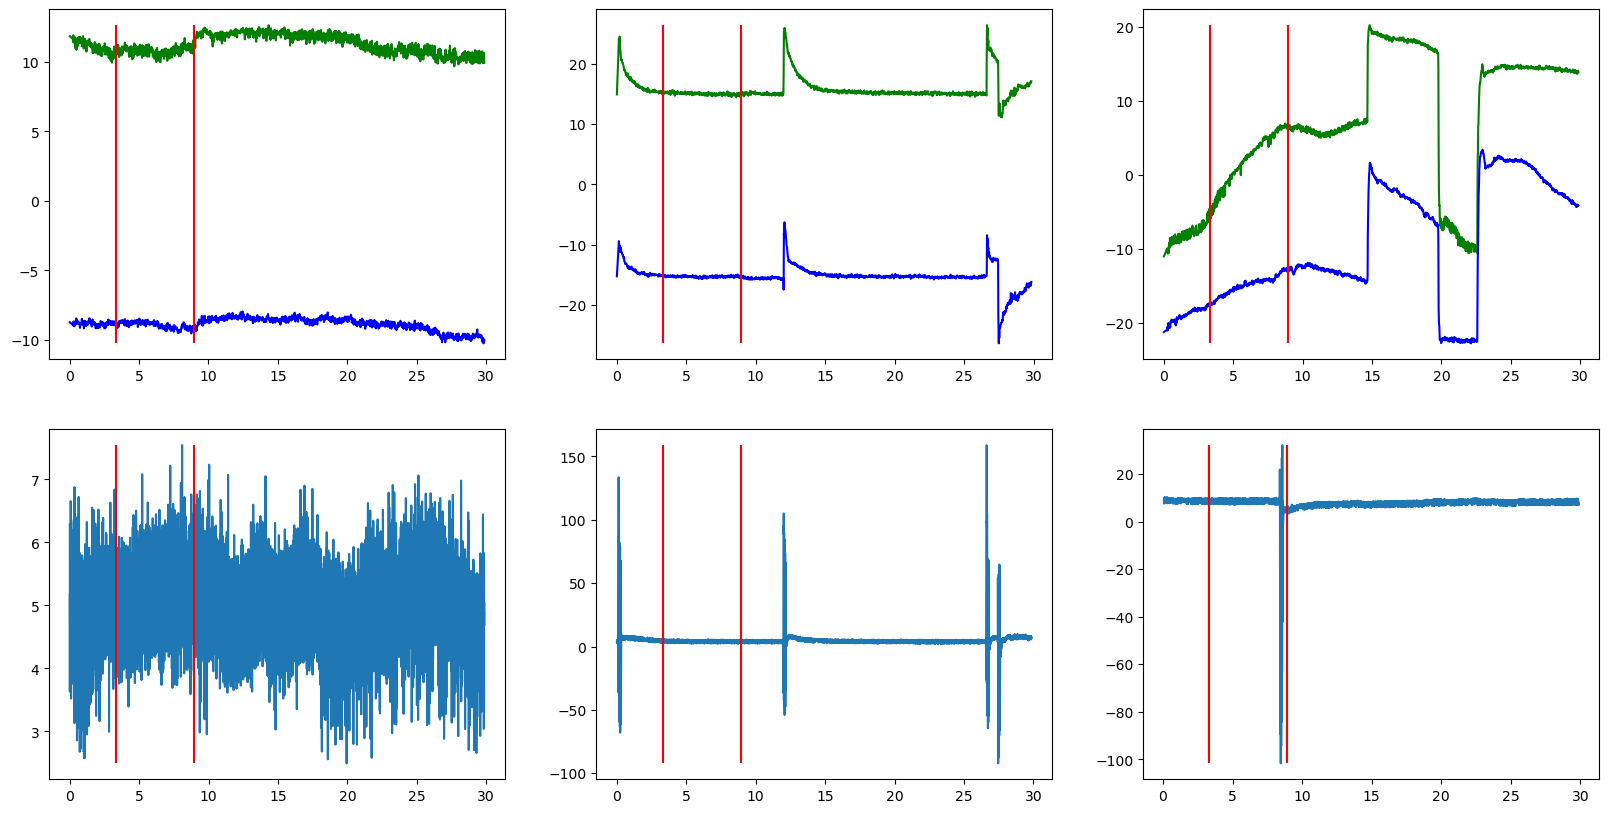

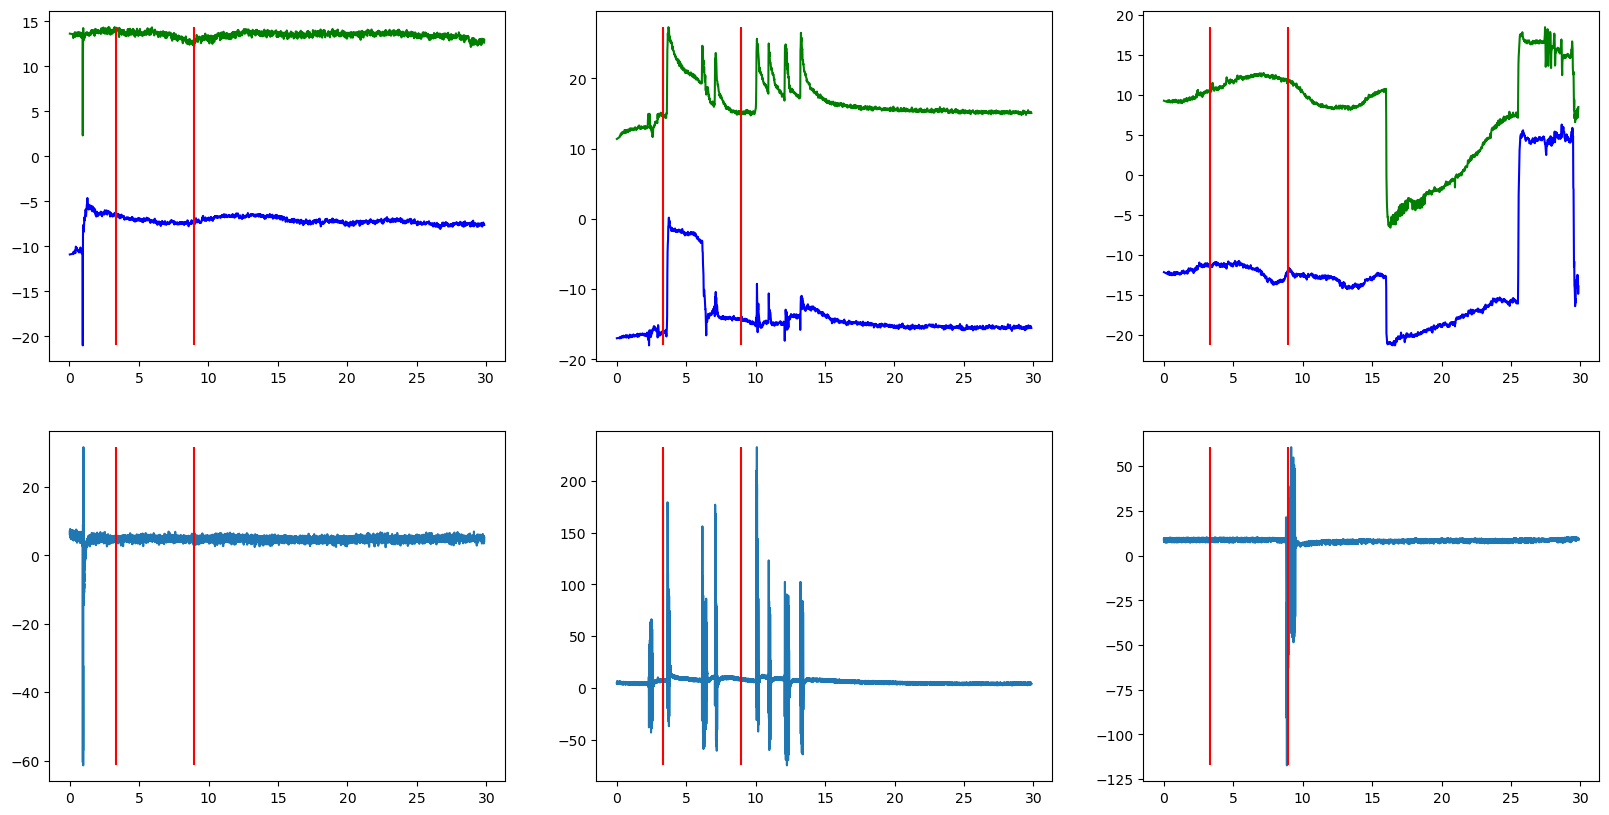

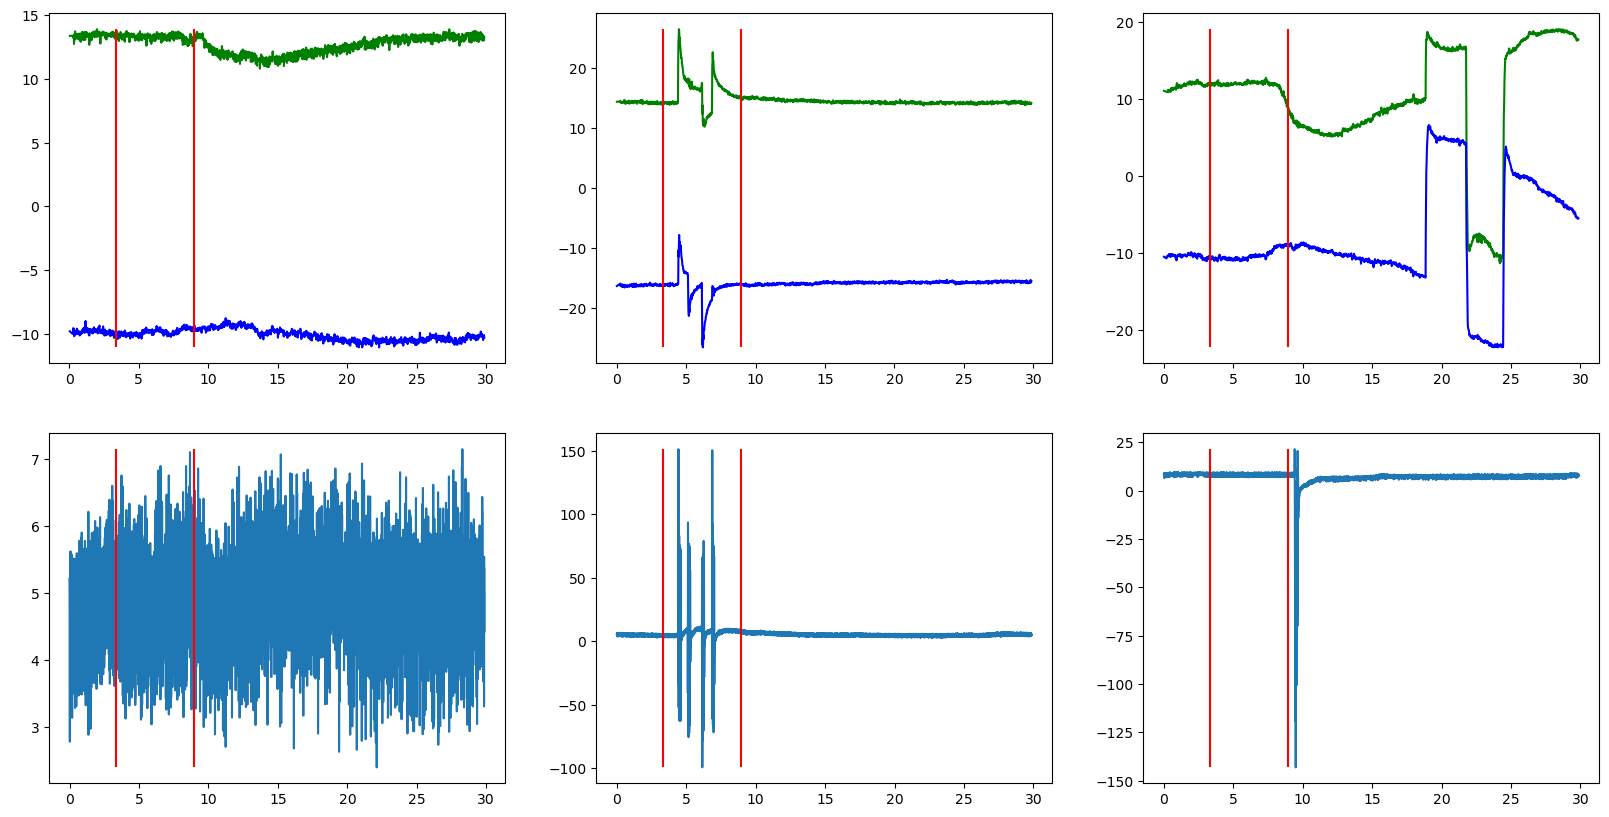

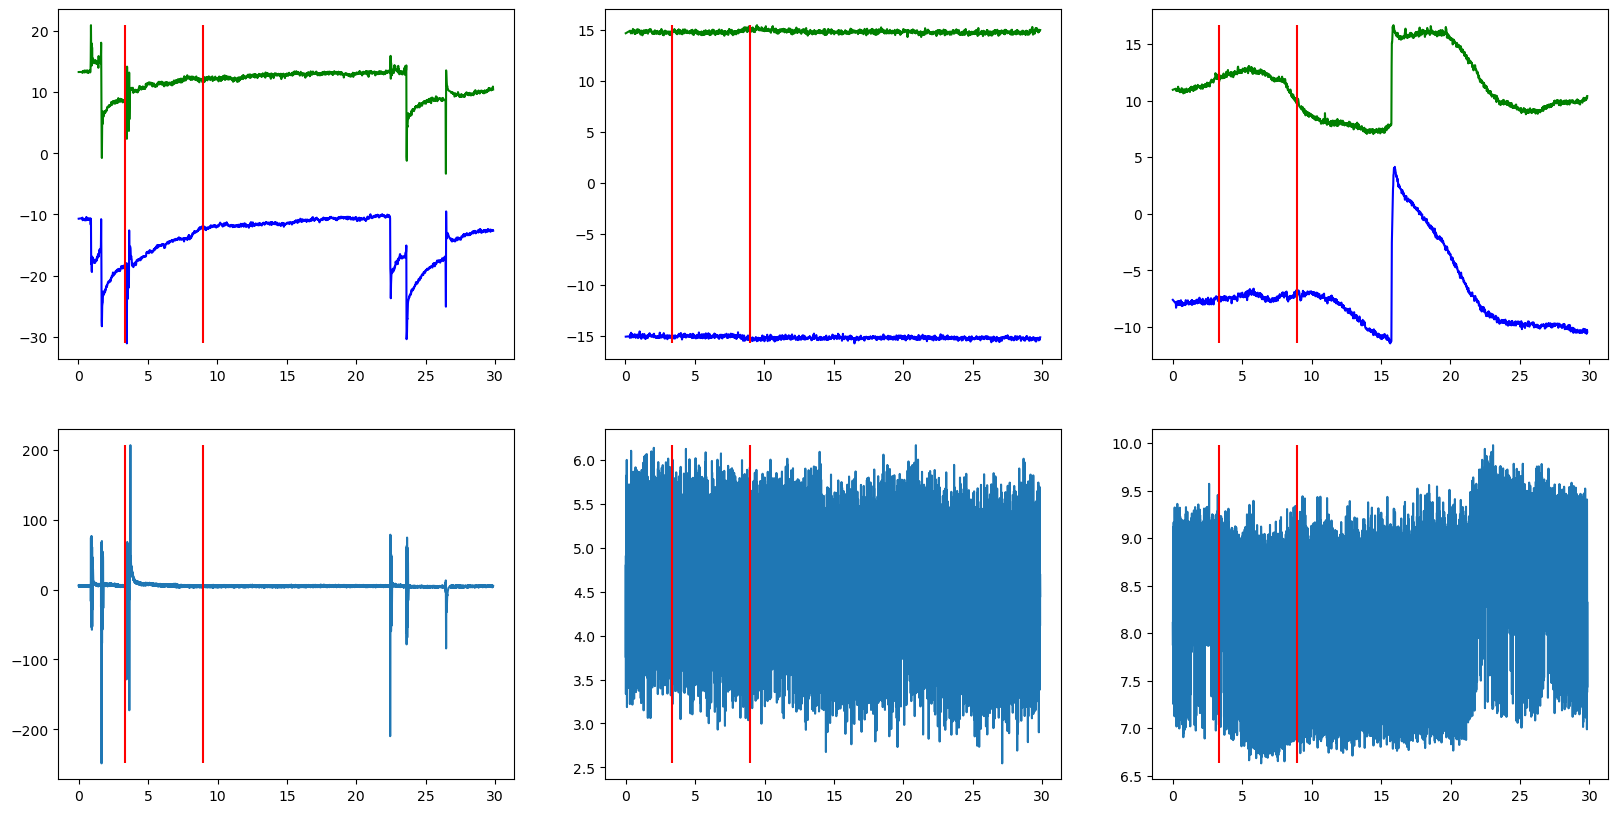

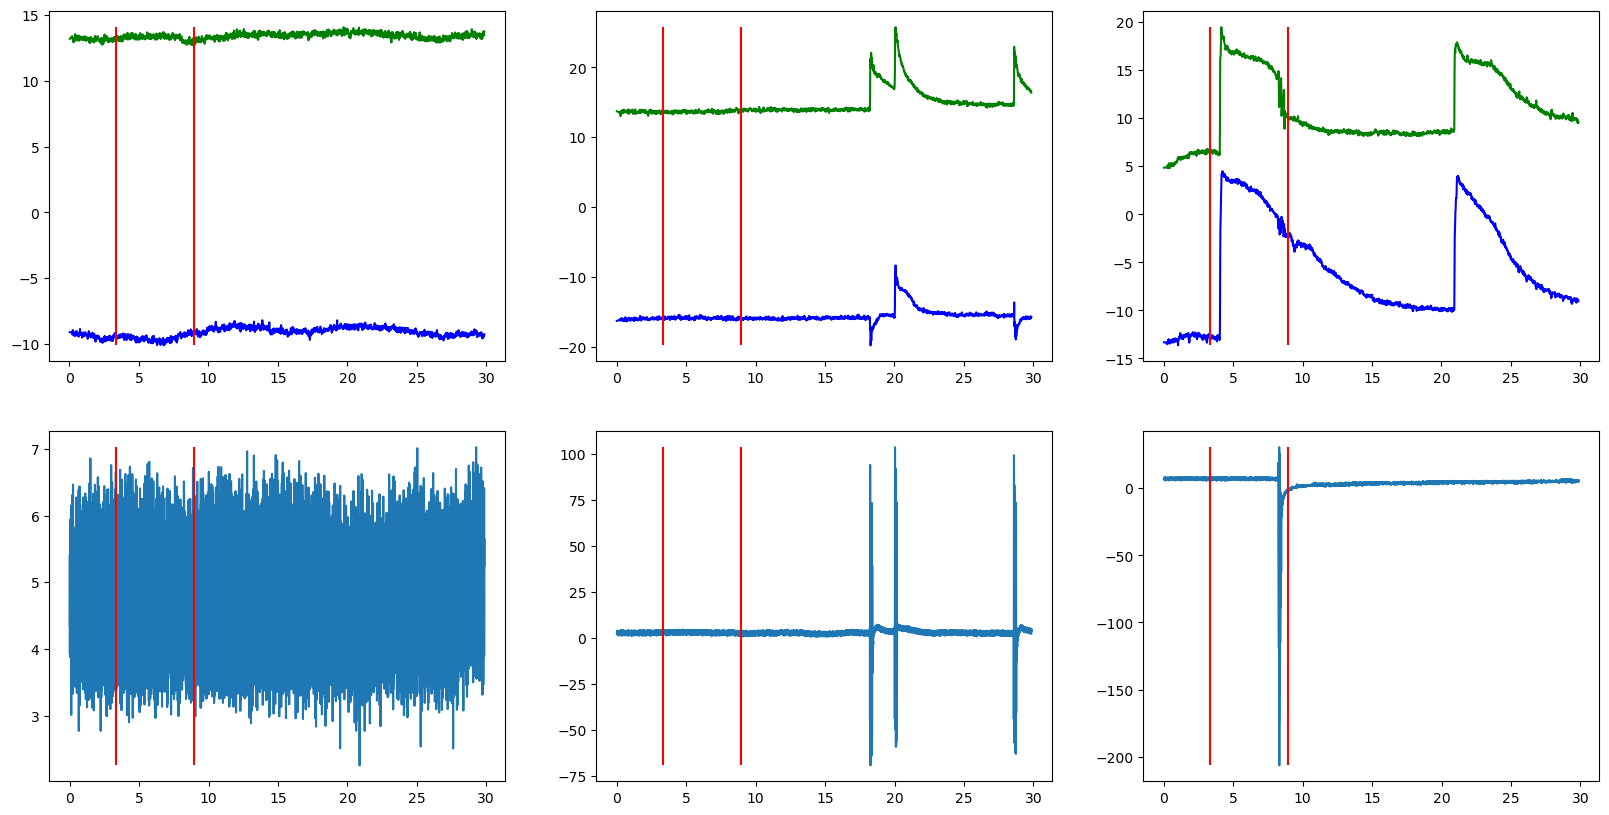

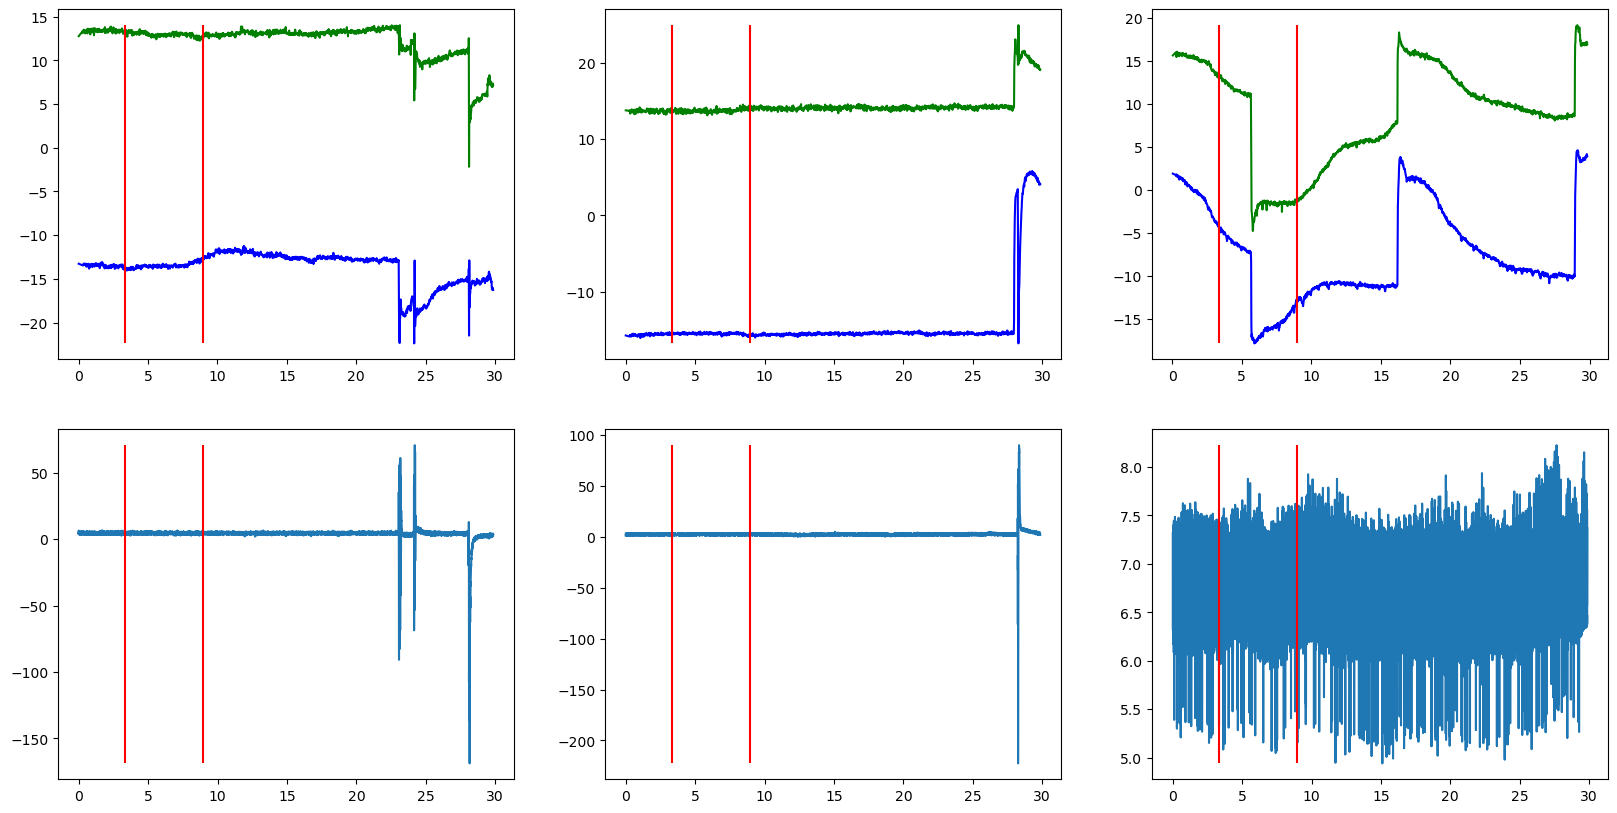

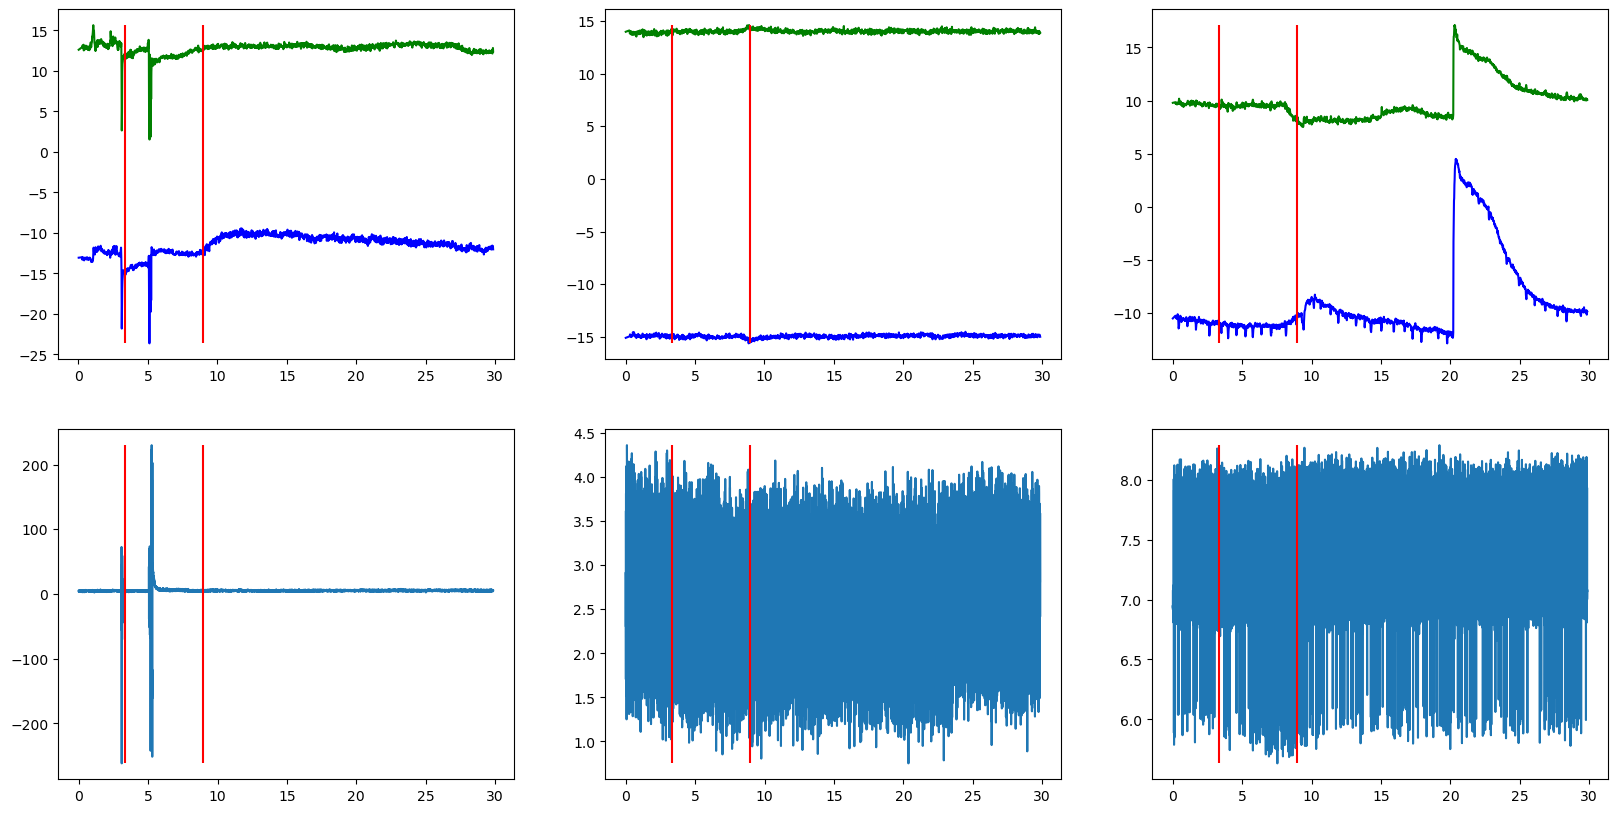

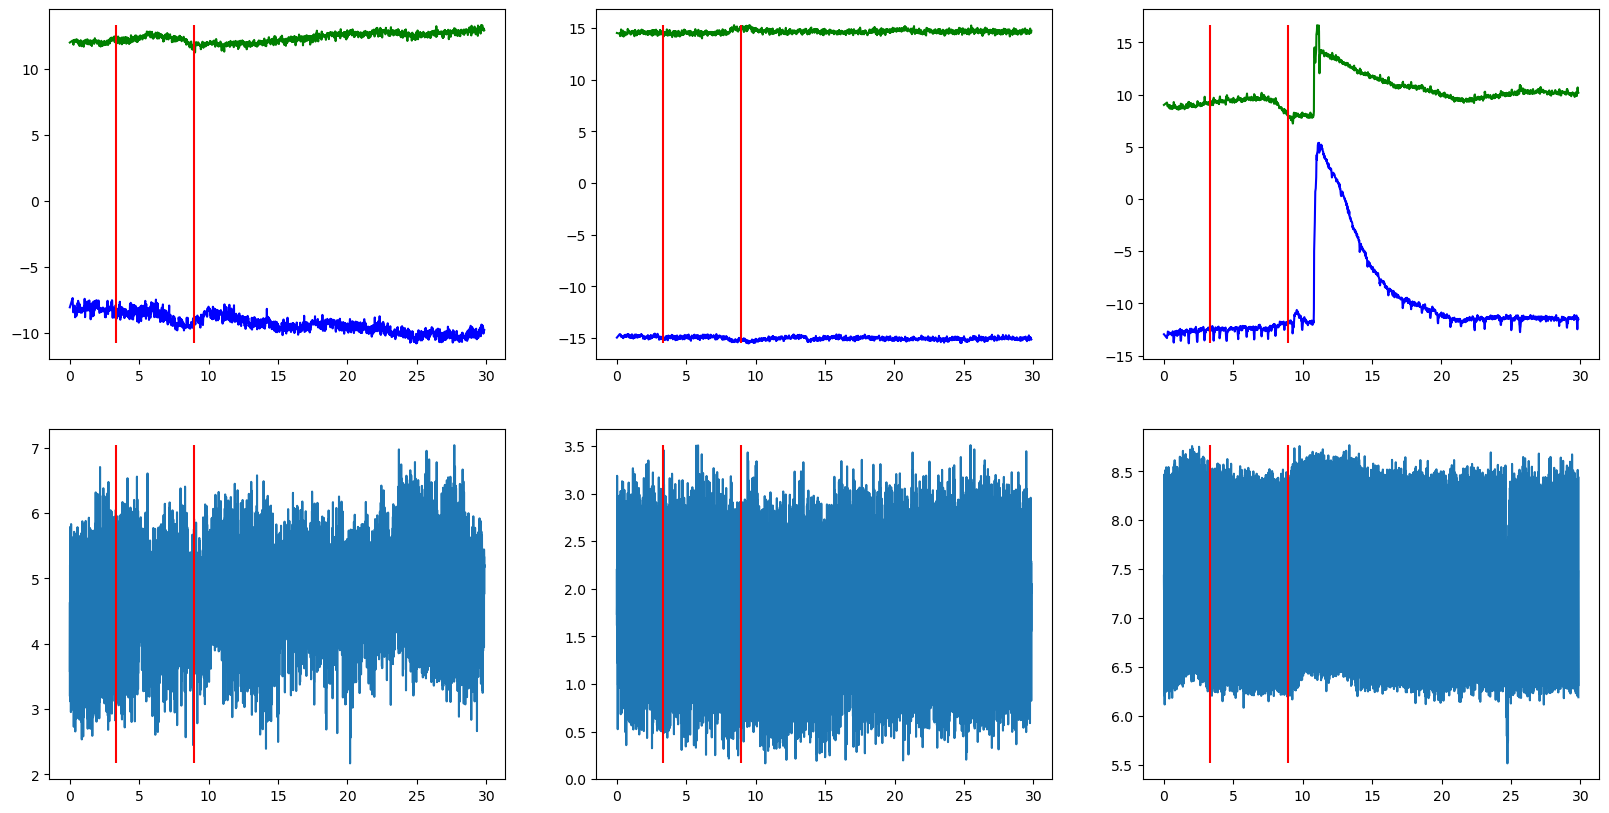

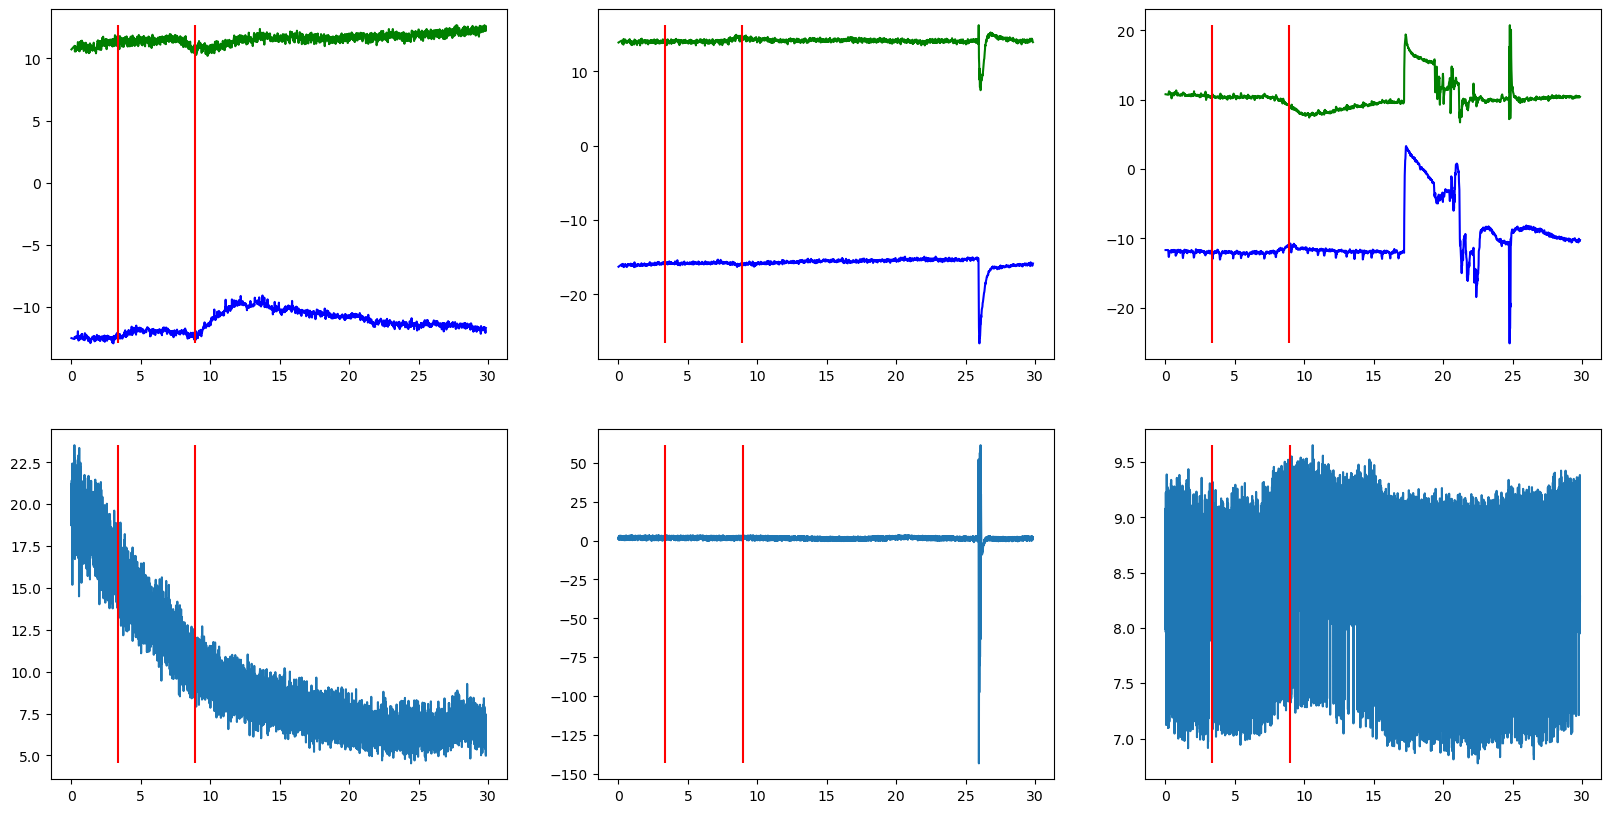

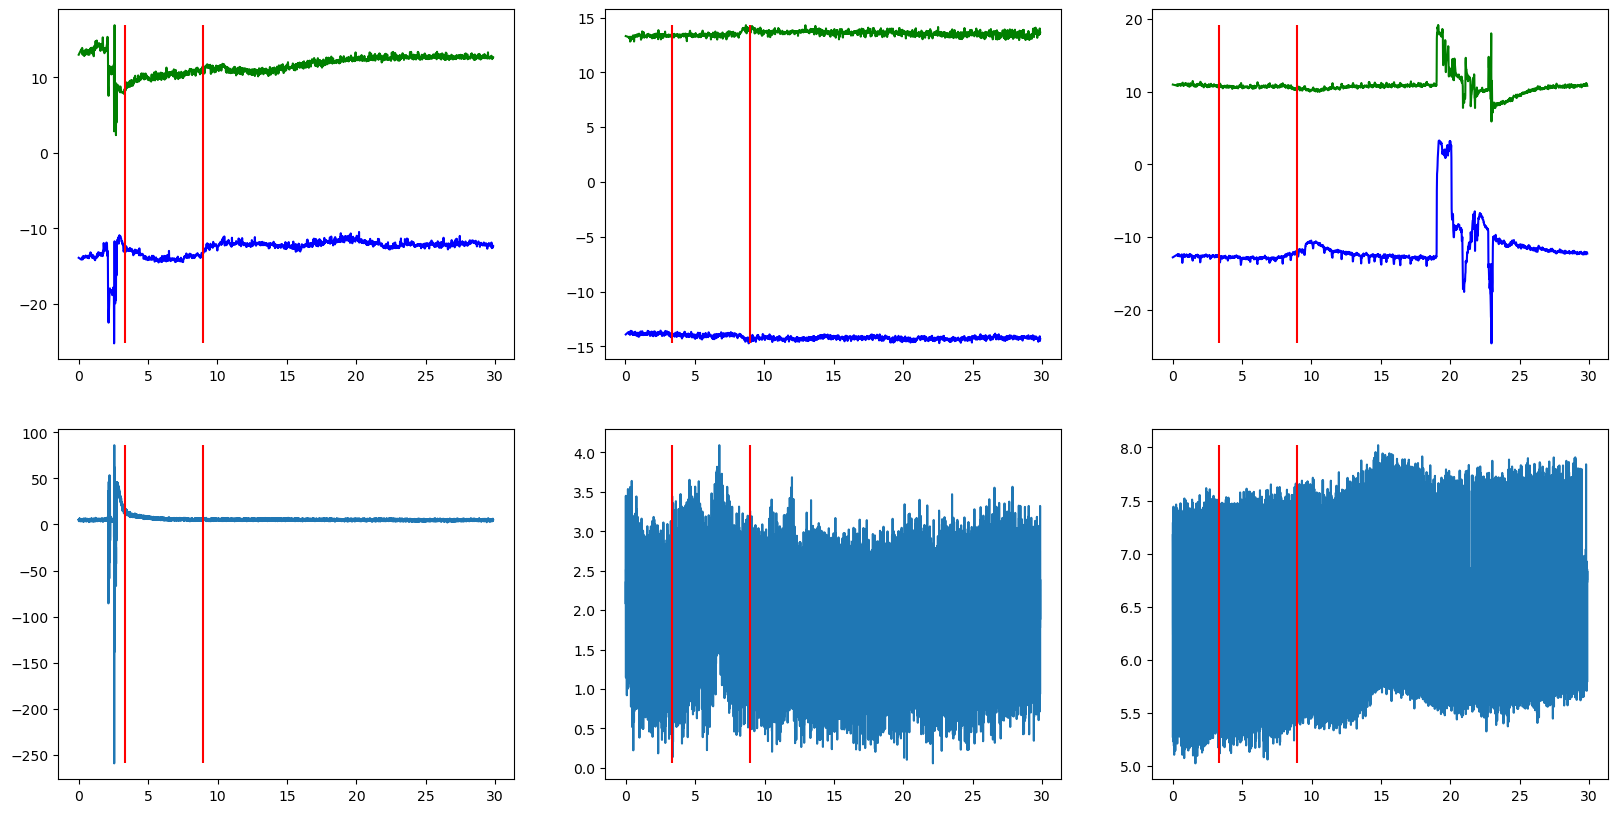

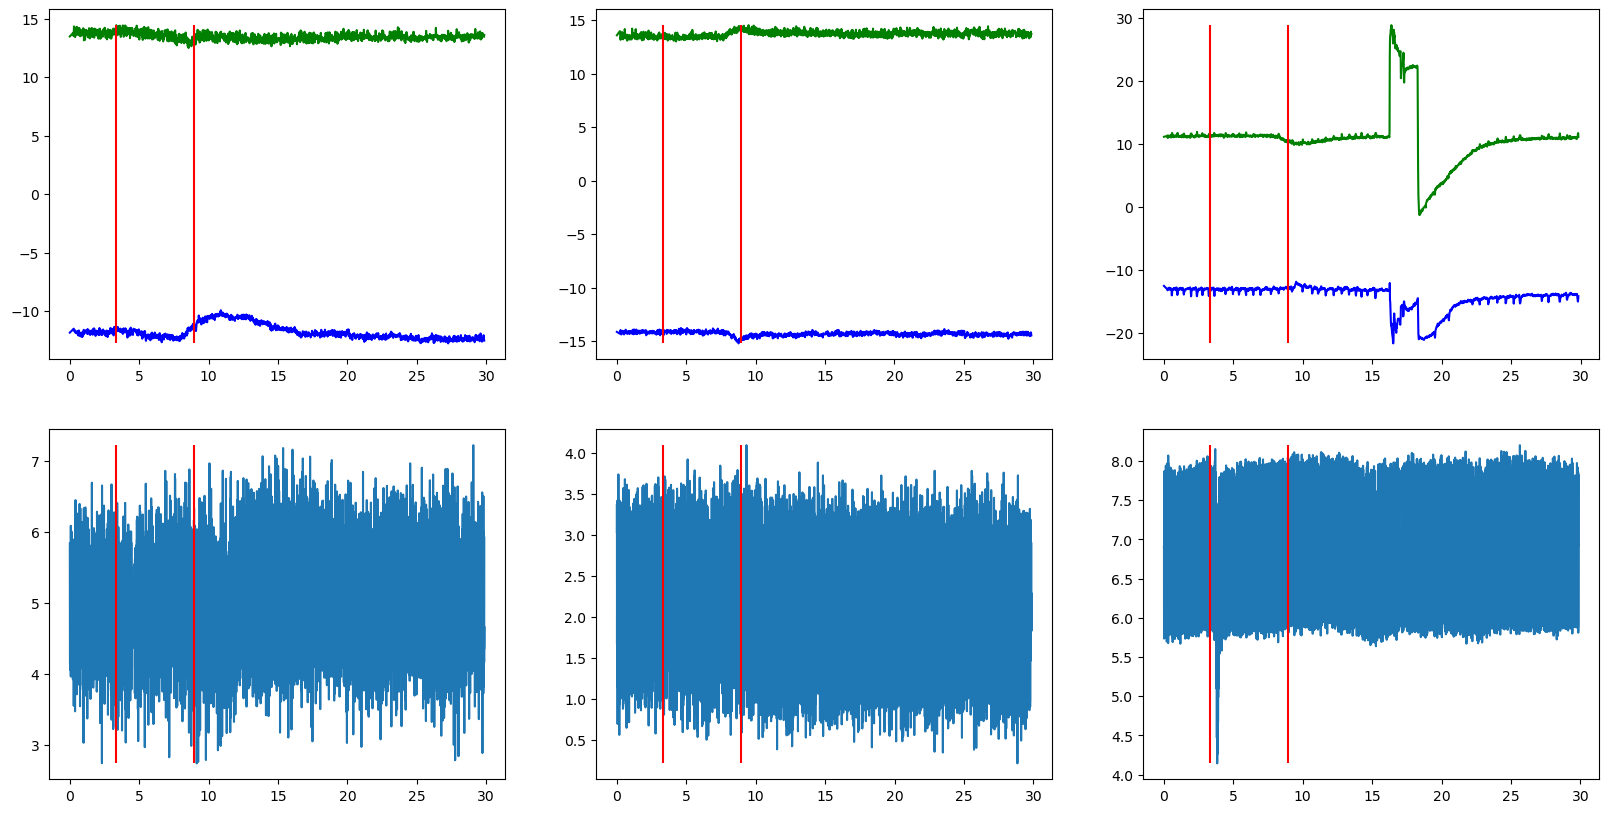

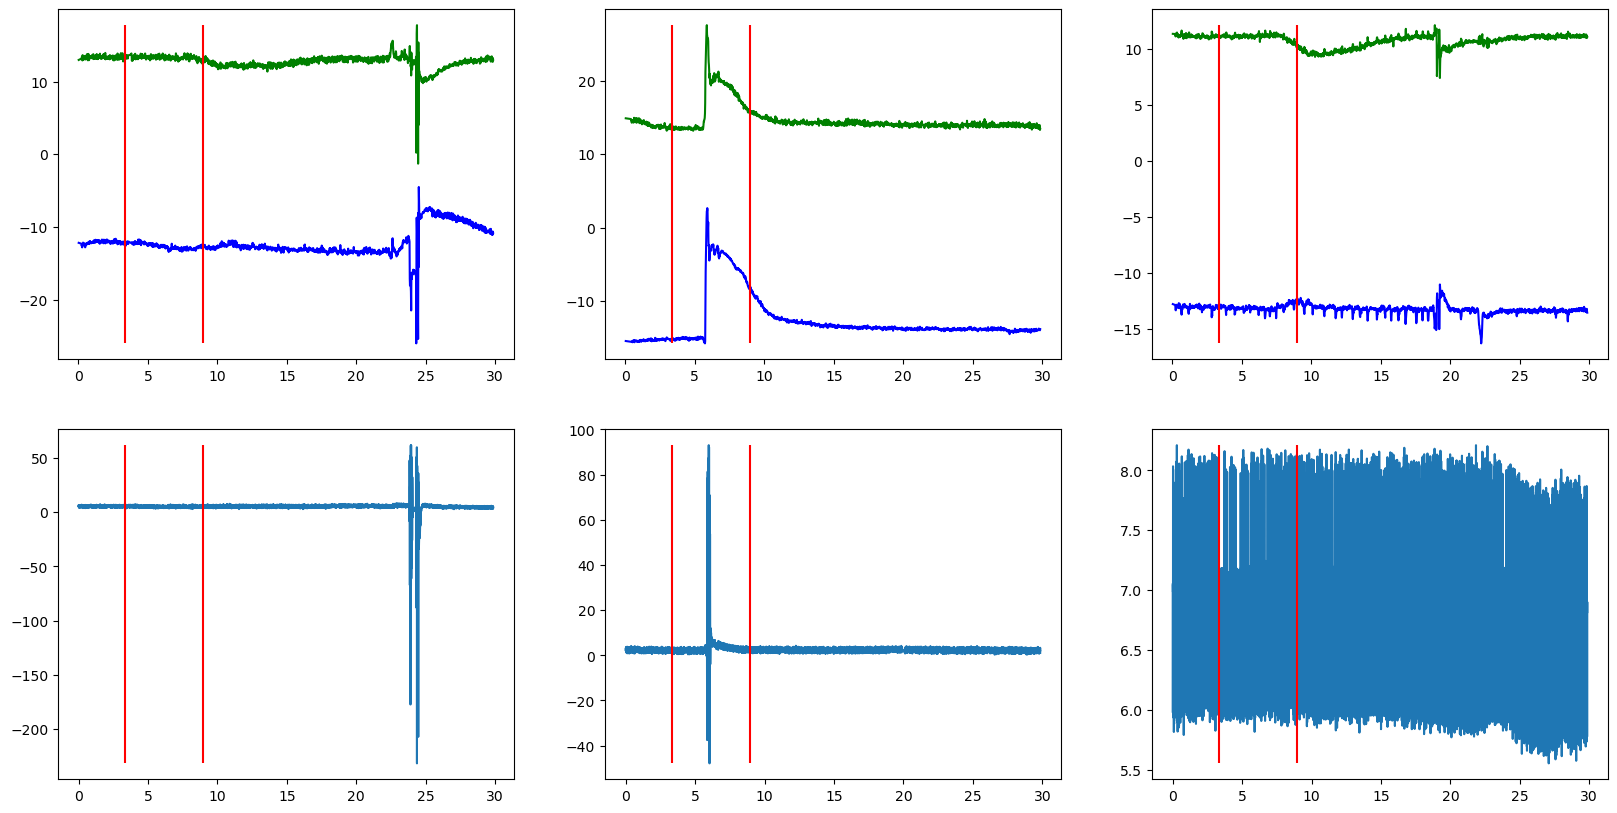

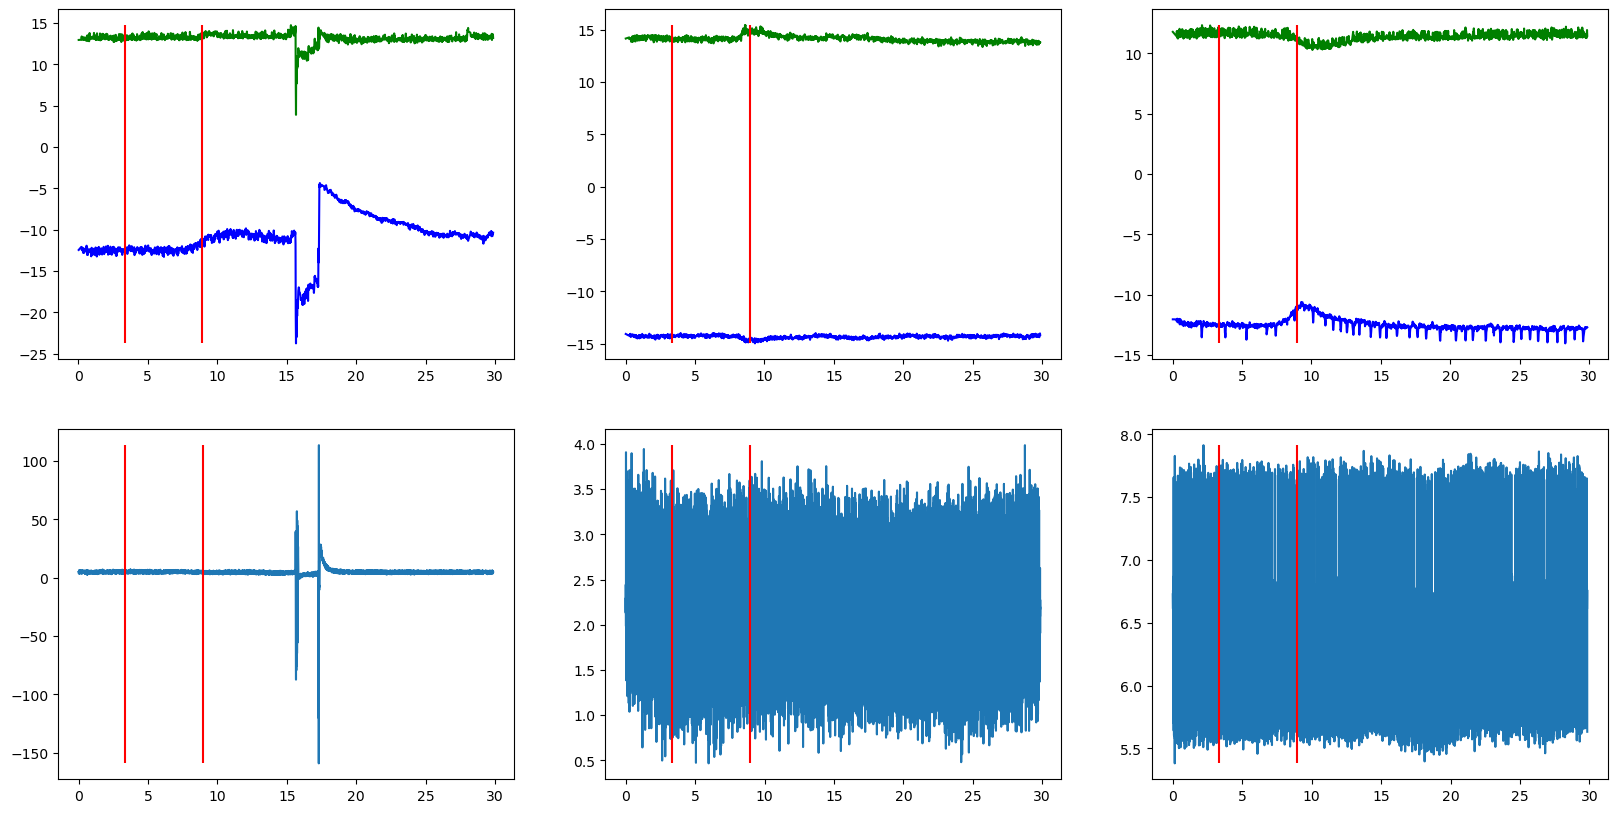

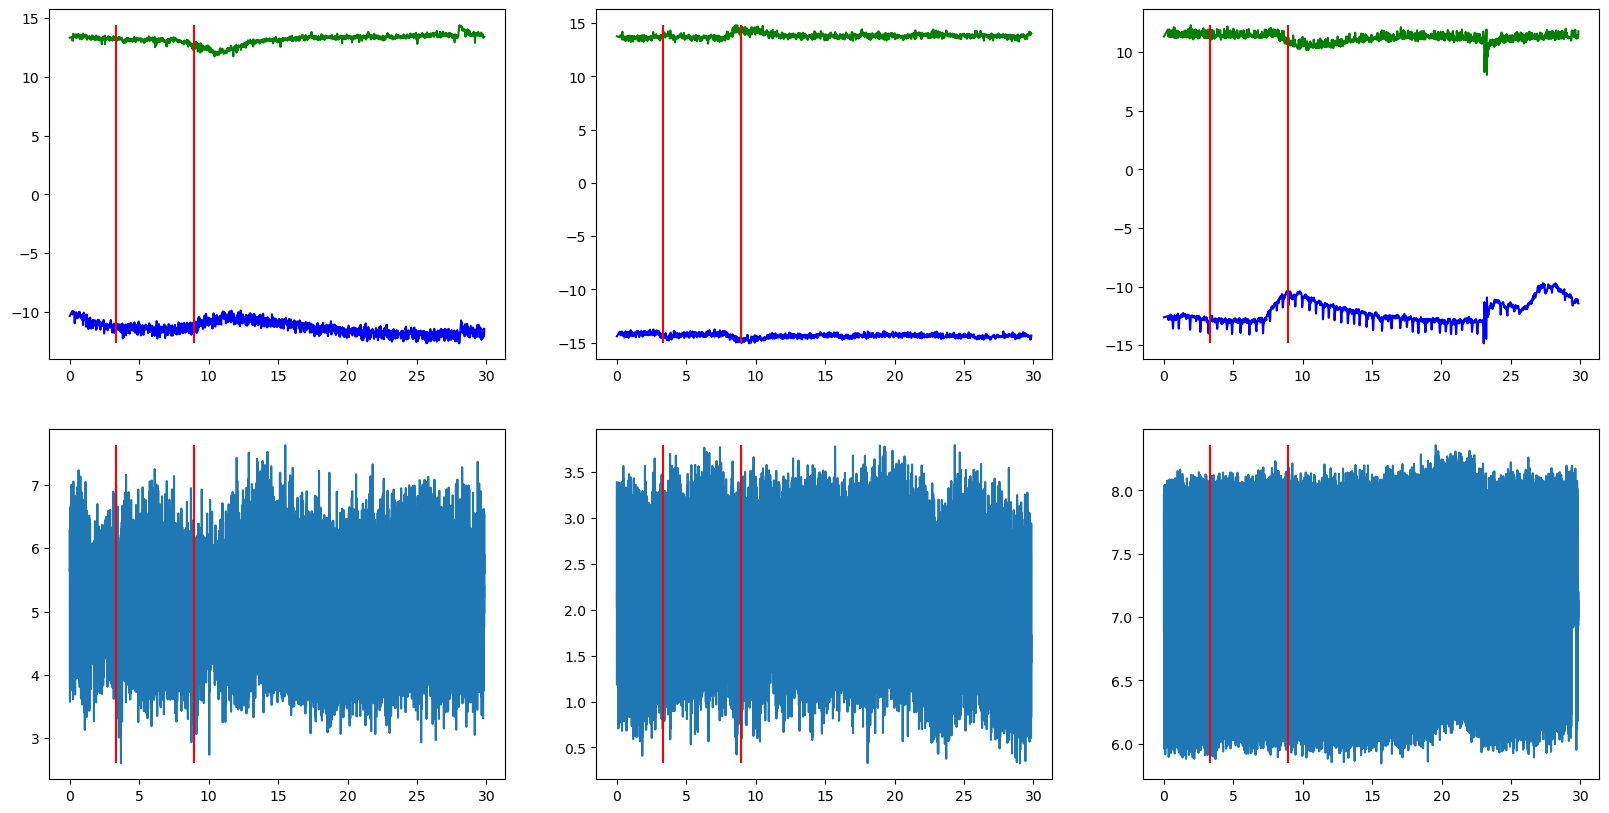

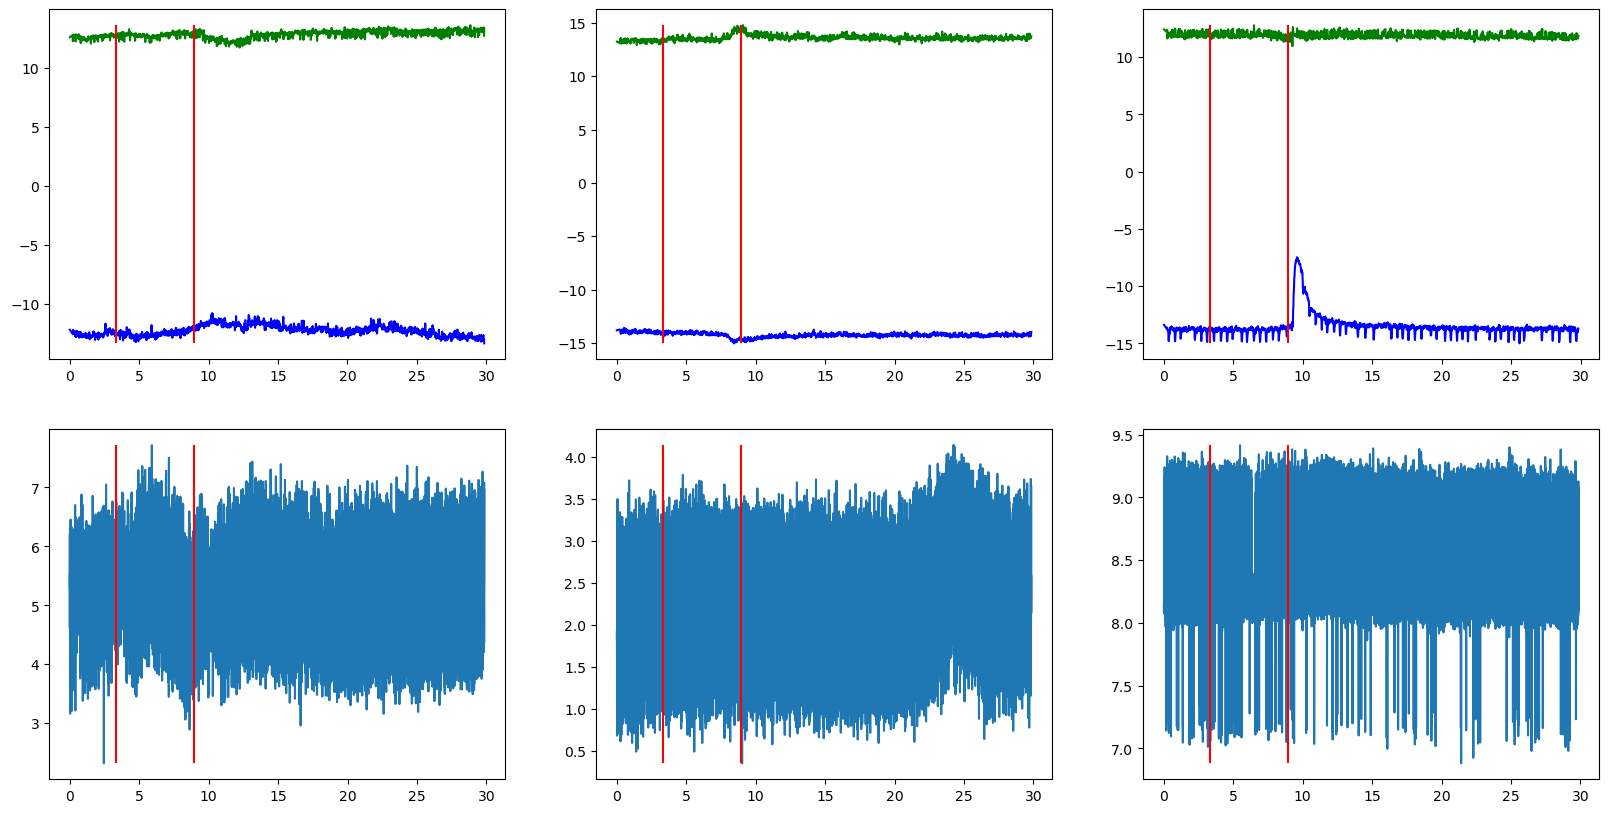

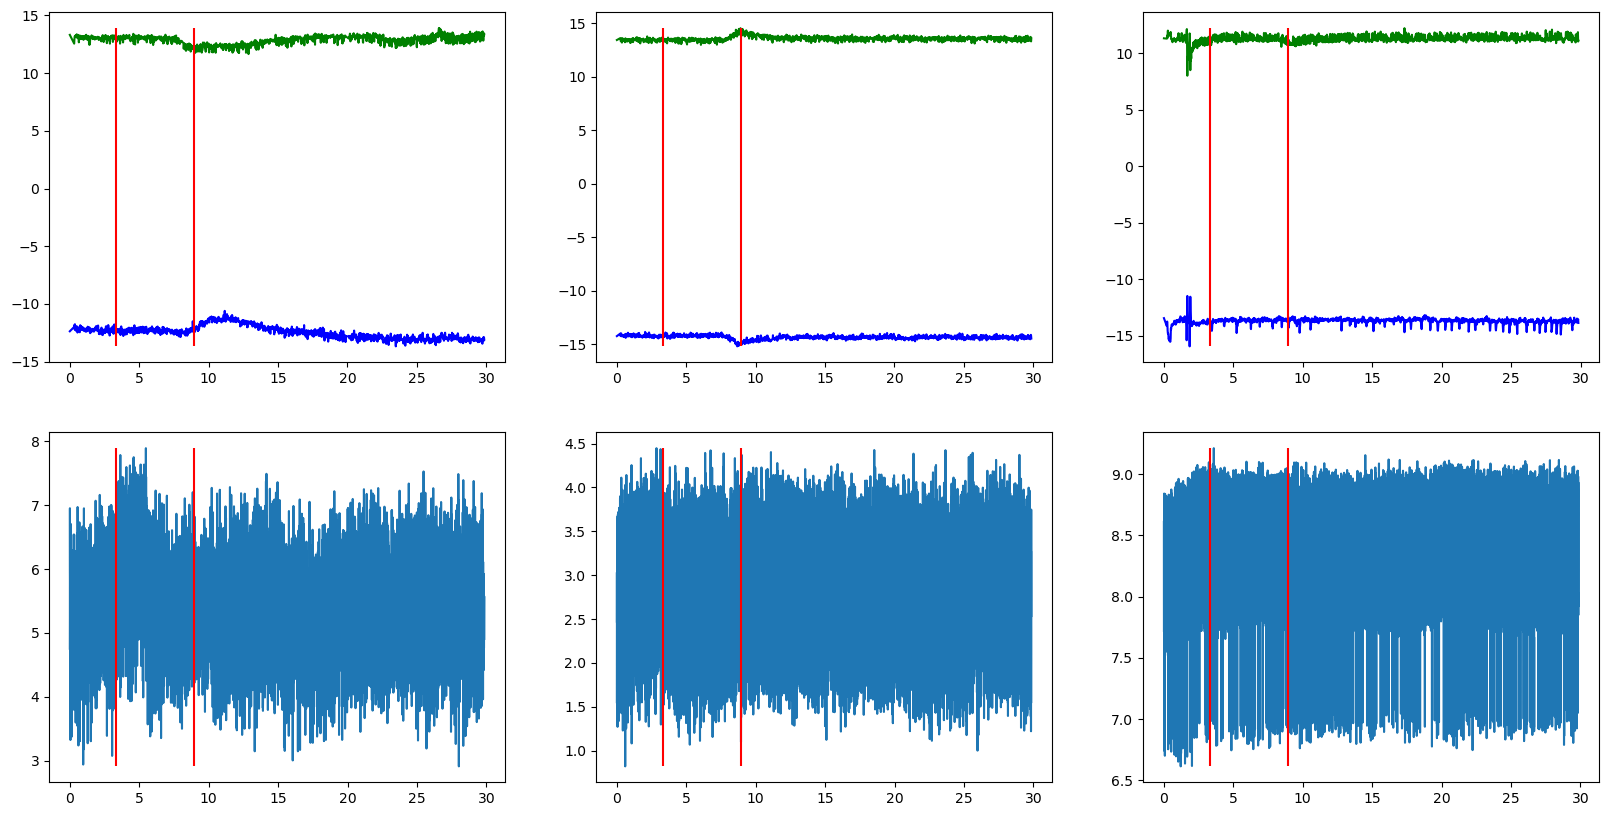

In [127]:
okr, mvb, loom = (12,10,5.6)
start = (1/3.6)*12
stop =start+loom
for epoch in epoch_lcf:
    fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(20, 10))

    ## Unexposed WT    
    axs[0,0].plot(gmb_wt['gmb']['p'][epoch]['tt'], gmb_wt['gmb']['p'][epoch]['Langles'], 'g')
    axs[0,0].plot(gmb_wt['gmb']['p'][epoch]['tt'], gmb_wt['gmb']['p'][epoch]['Rangles'], 'b')
    axs[0,0].vlines(start, ymin= min(gmb_wt['gmb']['p'][epoch]['Rangles']), ymax = max(gmb_wt['gmb']['p'][epoch]['Langles']), color='red')
    axs[0,0].vlines(stop, ymin= min(gmb_wt['gmb']['p'][epoch]['Rangles']), ymax = max(gmb_wt['gmb']['p'][epoch]['Langles']), color='red')

    ## Exposed WT
    axs[0,1].plot(gmb_wte['gmb']['p'][epoch]['tt'], gmb_wte['gmb']['p'][epoch]['Langles'], 'g')
    axs[0,1].plot(gmb_wte['gmb']['p'][epoch]['tt'], gmb_wte['gmb']['p'][epoch]['Rangles'], 'b')
    axs[0,1].vlines(start, ymin= min(gmb_wte['gmb']['p'][epoch]['Rangles']), ymax = max(gmb_wte['gmb']['p'][epoch]['Langles']),color='red')
    axs[0,1].vlines(stop, ymin= min(gmb_wte['gmb']['p'][epoch]['Rangles']), ymax = max(gmb_wte['gmb']['p'][epoch]['Langles']),color='red')

    ## Exposed mutants
    axs[0,2].plot(gmb_mute['gmb']['p'][epoch]['tt'], gmb_mute['gmb']['p'][epoch]['Langles'], 'g')
    axs[0,2].plot(gmb_mute['gmb']['p'][epoch]['tt'], gmb_mute['gmb']['p'][epoch]['Rangles'], 'b')
    axs[0,2].vlines(start, ymin= min(gmb_mute['gmb']['p'][epoch]['Rangles']), ymax = max(gmb_mute['gmb']['p'][epoch]['Langles']), color='red')
    axs[0,2].vlines(stop, ymin= min(gmb_mute['gmb']['p'][epoch]['Rangles']), ymax = max(gmb_mute['gmb']['p'][epoch]['Langles']), color='red')

    ##    
    axs[1,0].plot(gmbt_wt['gmbt']['p'][epoch]['tt'], gmbt_wt['gmbt']['p'][epoch]['cumtail'])
    axs[1,0].vlines(start, ymin= min(gmbt_wt['gmbt']['p'][epoch]['cumtail']), ymax = max(gmbt_wt['gmbt']['p'][epoch]['cumtail']), color='red')
    axs[1,0].vlines(stop, ymin= min(gmbt_wt['gmbt']['p'][epoch]['cumtail']), ymax = max(gmbt_wt['gmbt']['p'][epoch]['cumtail']), color='red')

    axs[1,1].plot(gmbt_wte['gmbt']['p'][epoch]['tt'], gmbt_wte['gmbt']['p'][epoch]['cumtail'])
    axs[1,1].vlines(start, ymin= min(gmbt_wte['gmbt']['p'][epoch]['cumtail']), ymax = max(gmbt_wte['gmbt']['p'][epoch]['cumtail']),color='red')
    axs[1,1].vlines(stop, ymin= min(gmbt_wte['gmbt']['p'][epoch]['cumtail']), ymax = max(gmbt_wte['gmbt']['p'][epoch]['cumtail']),color='red')

    axs[1,2].plot(gmbt2_mute['gmbt']['p'][epoch]['tt'], gmbt2_mute['gmbt']['p'][epoch]['cumtail'])
    axs[1,2].vlines(start, ymin= min(gmbt2_mute['gmbt']['p'][epoch]['cumtail']), ymax = max(gmbt2_mute['gmbt']['p'][epoch]['cumtail']),color='red')
    axs[1,2].vlines(stop, ymin= min(gmbt2_mute['gmbt']['p'][epoch]['cumtail']), ymax = max(gmbt2_mute['gmbt']['p'][epoch]['cumtail']),color='red')
    plt.savefig(f'tail_movement_{epoch}.png')

##plt.show()
plt.savefig('tail_movement.png')

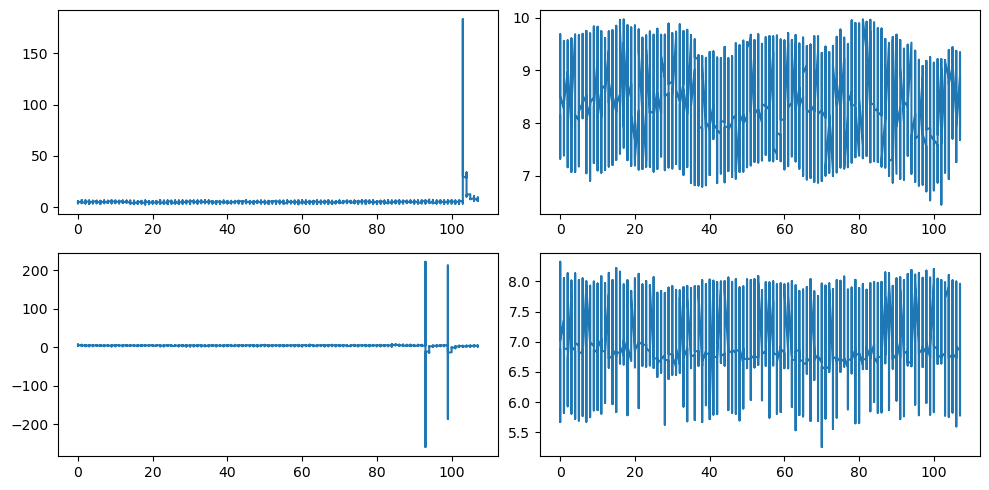

In [118]:
epoch, epoch1 = 62, 88
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10, 5))

axs[0,0].plot(gmbt_wt['gmbt']['p'][epoch]['fr'], gmbt_wt['gmbt']['p'][epoch]['cumtail'])
axs[1,0].plot(gmbt_wt['gmbt']['p'][epoch1]['fr'], gmbt_wt['gmbt']['p'][epoch1]['cumtail'])
    
axs[0,1].plot(gmbt2_mute['gmbt']['p'][epoch]['fr'], gmbt2_mute['gmbt']['p'][epoch]['cumtail'])
axs[1,1].plot(gmbt2_mute['gmbt']['p'][epoch1]['fr'], gmbt2_mute['gmbt']['p'][epoch1]['cumtail'])

plt.tight_layout()

plt.show()

In [25]:
%who

LCF	 LF	 LMB1	 LMB2	 LMB3	 LMB4	 OKR1	 OKR2	 OKR3	 
OKR4	 OKR5	 Path	 RMB1	 RMB2	 RMB3	 RMB4	 axs	 butter	 
correlate	 detect_tail_bouts	 df	 ep	 epoch	 epoch_lcf	 epoch_lf	 epoch_lmb1	 epoch_lmb2	 
epoch_lmb3	 epoch_lmb4	 epoch_okr1	 epoch_okr2	 epoch_okr3	 epoch_okr4	 epoch_okr5	 epoch_rmb1	 epoch_rmb2	 
epoch_rmb3	 epoch_rmb4	 extract_tail_bout_features_and_windows	 fft	 fftfreq	 fig	 filtfilt	 find_peaks	 gmb1_mute	 
gmb2_mute	 gmb3_mute	 gmb_mute	 gmb_wt	 gmb_wt2	 gmb_wte	 gmbt1_mute	 gmbt2_mute	 gmbt3_mute	 
gmbt_mute	 gmbt_wt	 gmbt_wt2	 gmbt_wte	 import_2p_data	 lru_cache	 mat73	 mute_gmb	 mute_gmb1	 
mute_gmb2	 mute_gmb3	 mute_gmbt	 mute_gmbt1	 mute_gmbt2	 mute_gmbt3	 neural_to_behaviour_alignment_single_roi	 np	 num	 
pd	 plot_tail_with_bouts	 plt	 stim	 stimulus_locked_behaviour	 summarize_bouts_stim_aligned	 v_stim	 warnings	 wt2_gmb	 
wt2_gmbt	 wt_gmb	 wt_gmbt	 wte_gmb	 wte_gmbt	 


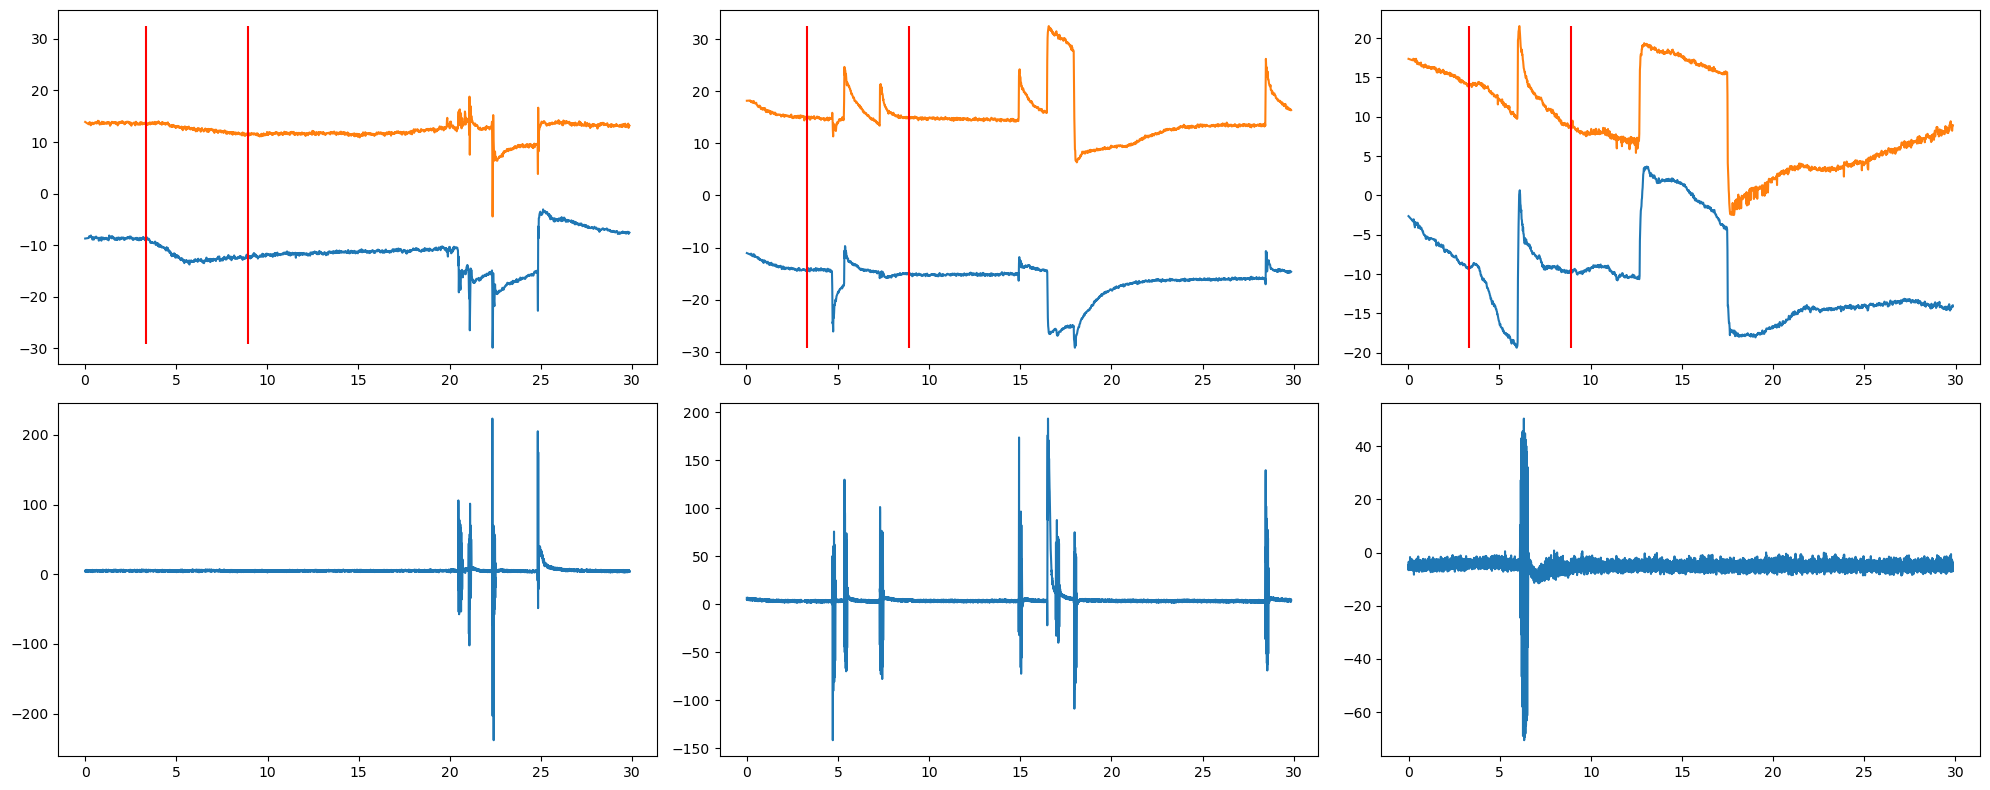

In [51]:
okr, mvb, loom = (12,10,5.6)
start = (1/3.6)*12
stop =start+loom

epoch = 11
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(20, 8))

axs[0,0].plot(gmb_wt['gmb']['p'][epoch]['tt'],gmb_wt['gmb']['p'][epoch]['Rangles'])
axs[0,0].plot(gmb_wt['gmb']['p'][epoch]['tt'],gmb_wt['gmb']['p'][epoch]['Langles'])
axs[1,0].plot(gmbt_wt['gmbt']['p'][epoch]['tt'],gmbt_wt['gmbt']['p'][epoch]['cumtail'])
axs[0,0].vlines(start, ymin= min(gmb_wte['gmb']['p'][epoch]['Rangles']), ymax = max(gmb_wte['gmb']['p'][epoch]['Langles']),color='red')
axs[0,0].vlines(stop, ymin= min(gmb_wte['gmb']['p'][epoch]['Rangles']), ymax = max(gmb_wte['gmb']['p'][epoch]['Langles']),color='red')
#axs[1,0].vlines(start, ymin= min(gmb_wte['gmb']['p'][epoch]['Rangles']), ymax = max(gmb_wte['gmb']['p'][epoch]['Langles']),color='red')
#axs[1,0].vlines(stop, ymin= min(gmb_wte['gmb']['p'][epoch]['Rangles']), ymax = max(gmb_wte['gmb']['p'][epoch]['Langles']),color='red')

axs[0,1].plot(gmb_wte['gmb']['p'][epoch]['tt'],gmb_wte['gmb']['p'][epoch]['Rangles'])
axs[0,1].plot(gmb_wte['gmb']['p'][epoch]['tt'],gmb_wte['gmb']['p'][epoch]['Langles'])
axs[1,1].plot(gmbt_wte['gmbt']['p'][epoch]['tt'],gmbt_wte['gmbt']['p'][epoch]['cumtail'])
axs[0,1].vlines(start, ymin= min(gmb_wte['gmb']['p'][epoch]['Rangles']), ymax = max(gmb_wte['gmb']['p'][epoch]['Langles']),color='red')
axs[0,1].vlines(stop, ymin= min(gmb_wte['gmb']['p'][epoch]['Rangles']), ymax = max(gmb_wte['gmb']['p'][epoch]['Langles']),color='red')
#axs[1,1].vlines(start, ymin= min(gmb_wte['gmb']['p'][epoch]['Rangles']), ymax = max(gmb_wte['gmb']['p'][epoch]['Langles']),color='red')
#axs[1,1].vlines(stop, ymin= min(gmb_wte['gmb']['p'][epoch]['Rangles']), ymax = max(gmb_wte['gmb']['p'][epoch]['Langles']),color='red')

axs[0,2].plot(gmb_mute['gmb']['p'][epoch]['tt'],gmb_mute['gmb']['p'][epoch]['Rangles'])
axs[0,2].plot(gmb_mute['gmb']['p'][epoch]['tt'],gmb_mute['gmb']['p'][epoch]['Langles'])
axs[1,2].plot(gmbt_mute['gmbt']['p'][epoch]['tt'],gmbt_mute['gmbt']['p'][epoch]['cumtail'])
axs[0,2].vlines(start, ymin= min(gmb_mute['gmb']['p'][epoch]['Rangles']), ymax = max(gmb_mute['gmb']['p'][epoch]['Langles']),color='red')
axs[0,2].vlines(stop, ymin= min(gmb_mute['gmb']['p'][epoch]['Rangles']), ymax = max(gmb_mute['gmb']['p'][epoch]['Langles']),color='red')
#axs[1,0].vlines(start, ymin= min(gmbt_mute['gmbt']['p'][epoch]['Rangles']), ymax = max(gmbt_mute['gmbt']['p'][epoch]['Langles']),color='red')
#axs[1,0].vlines(stop, ymin= min(gmbt_mute['gmbt']['p'][epoch]['Rangles']), ymax = max(gmbt_mute['gmbt']['p'][epoch]['Langles']),color='red')

plt.tight_layout()

plt.show()

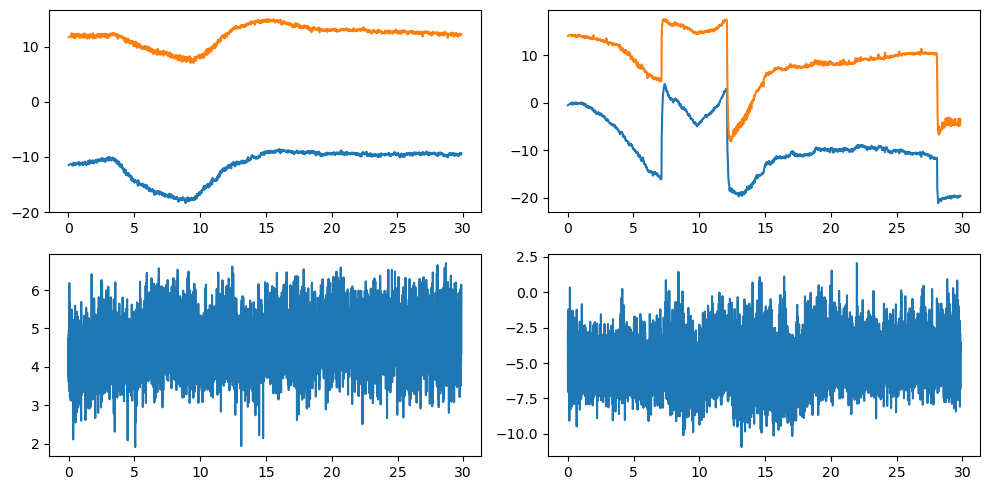

In [84]:

epoch = 16
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10, 5))

axs[0,0].plot(gmb_wt['gmb']['p'][epoch]['tt'],gmb_wt['gmb']['p'][epoch]['Rangles'])
axs[0,0].plot(gmb_wt['gmb']['p'][epoch]['tt'],gmb_wt['gmb']['p'][epoch]['Langles'])
axs[1,0].plot(wt_gmbt['gmbt']['p'][epoch]['tt'],wt_gmbt['gmbt']['p'][epoch]['cumtail'])

axs[0,1].plot(gmb_mute['gmb']['p'][epoch]['tt'],gmb_mute['gmb']['p'][epoch]['Rangles'])
axs[0,1].plot(gmb_mute['gmb']['p'][epoch]['tt'],gmb_mute['gmb']['p'][epoch]['Langles'])
axs[1,1].plot(mut_gmbt['gmbt']['p'][epoch]['tt'],mut_gmbt['gmbt']['p'][epoch]['cumtail'])

plt.tight_layout()

plt.show()

In [ ]:
epoch = 11
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10, 5))

axs[0,0].plot(gmb_wt['gmb']['p'][epoch]['tt'],gmb_wt['gmb']['p'][epoch]['Rangles'])
axs[0,0].plot(gmb_wt['gmb']['p'][epoch]['tt'],gmb_wt['gmb']['p'][epoch]['Langles'])
axs[1,0].plot(wt_gmbt['gmbt']['p'][epoch]['tt'],wt_gmbt['gmbt']['p'][epoch]['cumtail'])

axs[0,1].plot(gmb_mute['gmb']['p'][epoch]['tt'],gmb_mute['gmb']['p'][epoch]['Rangles'])
axs[0,1].plot(gmb_mute['gmb']['p'][epoch]['tt'],gmb_mute['gmb']['p'][epoch]['Langles'])
axs[1,1].plot(mut_gmbt['gmbt']['p'][epoch]['tt'],mut_gmbt['gmbt']['p'][epoch]['cumtail'])

plt.tight_layout()

plt.show()

TypeError: 'PosixPath' object is not subscriptable

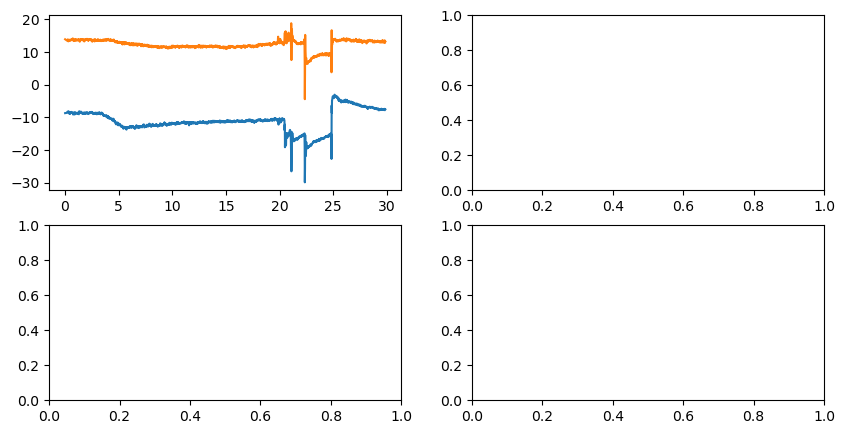

In [23]:
epoch = 11
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10, 5))

axs[0,0].plot(gmb_wt['gmb']['p'][epoch]['tt'],gmb_wt['gmb']['p'][epoch]['Rangles'])
axs[0,0].plot(gmb_wt['gmb']['p'][epoch]['tt'],gmb_wt['gmb']['p'][epoch]['Langles'])
axs[1,0].plot(wt_gmbt['gmbt']['p'][epoch]['tt'],wt_gmbt['gmbt']['p'][epoch]['cumtail'])

axs[0,1].plot(gmb_mute['gmb']['p'][epoch]['tt'],gmb_mute['gmb']['p'][epoch]['Rangles'])
axs[0,1].plot(gmb_mute['gmb']['p'][epoch]['tt'],gmb_mute['gmb']['p'][epoch]['Langles'])
axs[1,1].plot(mut_gmbt['gmbt']['p'][epoch]['tt'],mut_gmbt['gmbt']['p'][epoch]['cumtail'])

plt.tight_layout()

plt.show()

In [7]:
for epoch in epoch_okr3:
    df = pd.DataFrame({'Time':gmb_wt['gmb']['p'][epoch]['tt'],
    'lefteye': gmb_wt['gmb']['p'][epoch]['Langles'],
    'righteye': gmb_wt['gmb']['p'][epoch]['Rangles']})

In [8]:
df

,Time,lefteye,righteye
0,0.011598,13.366348,-13.637164
1,0.235598,12.546770,-14.013276
2,0.262598,12.373605,-14.347534
3,0.278598,12.901012,-13.873570
4,0.297598,12.860963,-14.094372
...,...,...,...
1731,29.781598,13.048483,-11.509500
1732,29.796598,12.680189,-11.216294
1733,29.814598,12.884268,-11.357402
1734,29.829598,12.748058,-11.528842


In [10]:
# 1. Preprocessing: Apply Butterworth low-pass filter
def butter_lowpass_filter(data, cutoff=10, fs=100, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

In [11]:
time = df['Time']
left_eye, right_eye = df['lefteye'], df['righteye']

In [12]:
filtered_left_eye = butter_lowpass_filter(left_eye)
filtered_right_eye = butter_lowpass_filter(right_eye)

In [13]:
# 2. Saccade Detection based on velocity threshold
def detect_saccades(eye_data, threshold=20):
    velocity = np.diff(eye_data) / np.diff(time)  # Compute velocity
    peaks, _ = find_peaks(np.abs(velocity), height=threshold)  # Identify saccades
    return peaks, velocity


In [14]:
left_saccades, left_velocity = detect_saccades(filtered_left_eye)
right_saccades, right_velocity = detect_saccades(filtered_right_eye)

In [15]:
left_velocity.mean()

-0.0012952940955060395

In [16]:
# 3. Cross-Correlation Analysis (synchrony between left and right eye movements)
def cross_correlation(x, y):
    correlation = correlate(x - np.mean(x), y - np.mean(y), mode='full')
    lag = np.arange(-len(x) + 1, len(x)) * np.mean(np.diff(time))  # Compute lag time
    return lag, correlation

In [17]:
lag, cross_corr = cross_correlation(filtered_left_eye, filtered_right_eye)

In [18]:
# 4. Frequency-Domain Analysis (FFT)
def compute_fft(signal, fs=100):
    n = len(signal)
    freq = fftfreq(n, d=1/fs)
    fft_values = np.abs(fft(signal))
    return freq[:n//2], fft_values[:n//2]

In [19]:
freqs_left, fft_left = compute_fft(filtered_left_eye)
freqs_right, fft_right = compute_fft(filtered_right_eye)
print (f'Peak: {left_saccades} and Velocity: {left_velocity}')
print (f'Peak: {right_saccades} and Velocity: {right_velocity}')

Peak: [333] and Velocity: [ -1.20728416  -8.5387397  -10.27200947 ...  -1.14745936  -0.51800313
   0.077992  ]
Peak: [331 344 347] and Velocity: [-0.7540116  -5.36064138 -6.51044509 ... -1.43480318 -2.56681699
 -2.77037185]


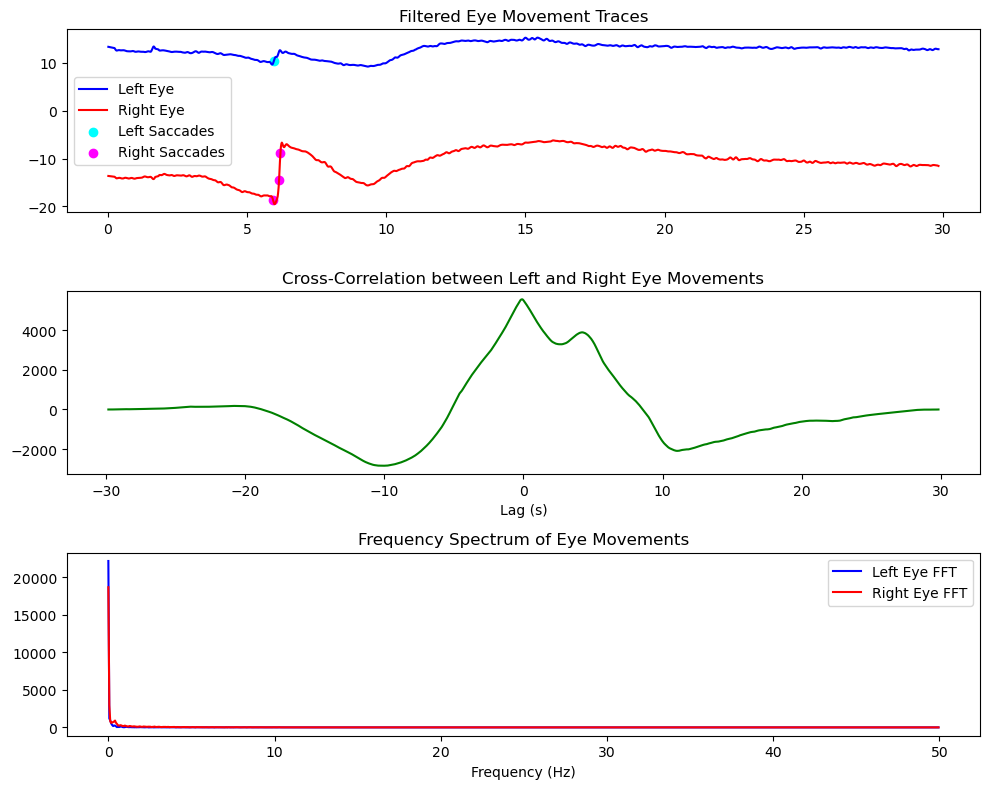

In [20]:
# Load sample data (replace with actual file path)
# The data should be a CSV with 'time', 'left_eye', 'right_eye' columns
data = df #pd.read_csv('eye_mov.csv')

time = data['Time'].values  # Time in seconds
left_eye = data['lefteye'].values  # Left eye position (degrees)
right_eye = data['righteye'].values  # Right eye position (degrees)

# Plot Results
fig, ax = plt.subplots(3, 1, figsize=(10, 8))

# Plot eye movement traces
ax[0].plot(time, filtered_left_eye, label='Left Eye', color='blue')
ax[0].plot(time, filtered_right_eye, label='Right Eye', color='red')
ax[0].scatter(time[left_saccades], filtered_left_eye[left_saccades], color='cyan', label='Left Saccades')
ax[0].scatter(time[right_saccades], filtered_right_eye[right_saccades], color='magenta', label='Right Saccades')
ax[0].set_title('Filtered Eye Movement Traces')
ax[0].legend()

# Plot cross-correlation
ax[1].plot(lag, cross_corr, color='green')
ax[1].set_title('Cross-Correlation between Left and Right Eye Movements')
ax[1].set_xlabel('Lag (s)')

# Plot FFT
ax[2].plot(freqs_left, fft_left, label='Left Eye FFT', color='blue')
ax[2].plot(freqs_right, fft_right, label='Right Eye FFT', color='red')
ax[2].set_title('Frequency Spectrum of Eye Movements')
ax[2].set_xlabel('Frequency (Hz)')
ax[2].legend()

plt.tight_layout()
plt.show()